# Projet Simulation

$$ SENES \space BOURRIE \space Quentin $$

<a id='0'></a>

# 0. Quelques rappels sur le modèle CIR (Cox–Ingersoll–Ross)

Le modèle CIR est un modèle stochastique couramment utilisé pour modéliser l'évolution des taux d'intérêt à court terme. En finance, il est particulièrement apprécié pour la modélisation des taux d'intérêt en raison de certaines de ses propriétés intéressantes, notamment la garantie que les taux d'intérêt restent toujours positifs (sous certaines conditions sur les paramètres).

**Le modèle CIR est défini par l'équation différentielle stochastique (EDS) :**

$$
\begin{cases}
    dR_t = \alpha (\beta - R_t) \, dt + \sigma \sqrt{R_t} \, dB_t \\
    R_0 = r_0
\end{cases}
$$

### Signification des paramètres

- **$R_t$** : taux d'intérêt à court terme à l'instant \( t \).

- **$\alpha$** : paramètre de vitesse de retour à la moyenne (*mean-reversion speed*), qui détermine la rapidité avec laquelle $R_t$ revient vers sa moyenne de long terme $\beta$. Une valeur élevée de $\alpha$ indique un retour rapide à la moyenne, tandis qu'une valeur faible signifie un retour plus lent.

 Attention : **$\alpha > 0$**
 
- **$\beta$** : taux moyen de long terme vers lequel $R_t$ tend à revenir. Ce paramètre représente la moyenne de long terme des taux d'intérêt.

- **$\sigma$** : volatilité du processus, qui contrôle l'amplitude des fluctuations du taux d'intérêt autour de sa moyenne. 

- **$B_t$** : mouvement brownien standard, loi normale


### Condition de FELLER (difficile à montrer)

- Si $ 2 \alpha \beta \geq \sigma^2 $, un processus CIR démarrant d'une condition initiale positive $ R_0 $ reste strictement positif.

- Si $ 0 \leq 2 \alpha \beta < \sigma^2 $, un processus CIR démarrant d'une condition initiale positive $ R_0 $ atteint zéro avec une probabilité $ p \in (0, 1) $ dans le cas où $ \alpha < 0 $ ; et presque sûrement dans le cas où $ \alpha \geq 0 $.

- Si $ 2 \alpha \beta < 0 $, un processus CIR démarrant d'une condition initiale positive $ R_0 $ atteint zéro presque sûrement.


**Conclusion :** Une fois nos paramètres estimés, nous devons nous assurer que $ 2 \alpha \beta \geq \sigma^2 $.

In [57]:
# Importation modules
import pandas as pd
import requests
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import seaborn as sns
from scipy.stats import shapiro, norm
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
import plotly.io as pio
import matplotlib.cm as cm
from matplotlib.lines import Line2D

# Chargement de l'IRX : Attention, API personnelle à demande limitée

In [ ]:
# Clé perso API Alpha Vantage
key_API = '***'

# Paramètres pour récupérer les taux d'intérêt du Trésor américain à 3 mois
function = 'TREASURY_YIELD'
interval = 'daily'  # Intervalle quotidien pour des données journalières
maturity = '3month'   # Taux de maturité de 3 mois (équivalent à IRX)

# Construire l'URL de requête
url = f'https://www.alphavantage.co/query?function={function}&interval={interval}&maturity={maturity}&apikey={key_API}'

# Effectuer la requête
response = requests.get(url)
data = response.json()

# Convertir les données en DataFrame
# Les données sont stockées dans la clé 'data' dans la réponse JSON
df_initial= pd.DataFrame(data['data'])

# Convertir la colonne de dates en format datetime
df_initial['date'] = pd.to_datetime(df_initial['date'])

# Supprimer les lignes avec des valeurs manquantes ou non numériques dans la colonne 'value'
df_initial = df_initial[df_initial['value'] != '.']

# Convertir la colonne de taux d'intérêt en float
df_initial['value'] = df_initial['value'].astype(float)

# Remplace toutes les valeurs de 'value' par leur valeur absolue
df_initial['value'] = df_initial['value'].abs()

# Trier les données par date
df_initial = df_initial.sort_values(by='date')

**Remarque :** Taux obligataire américain échéance 3 mois. (Bonne référence pour un taux sans risque)

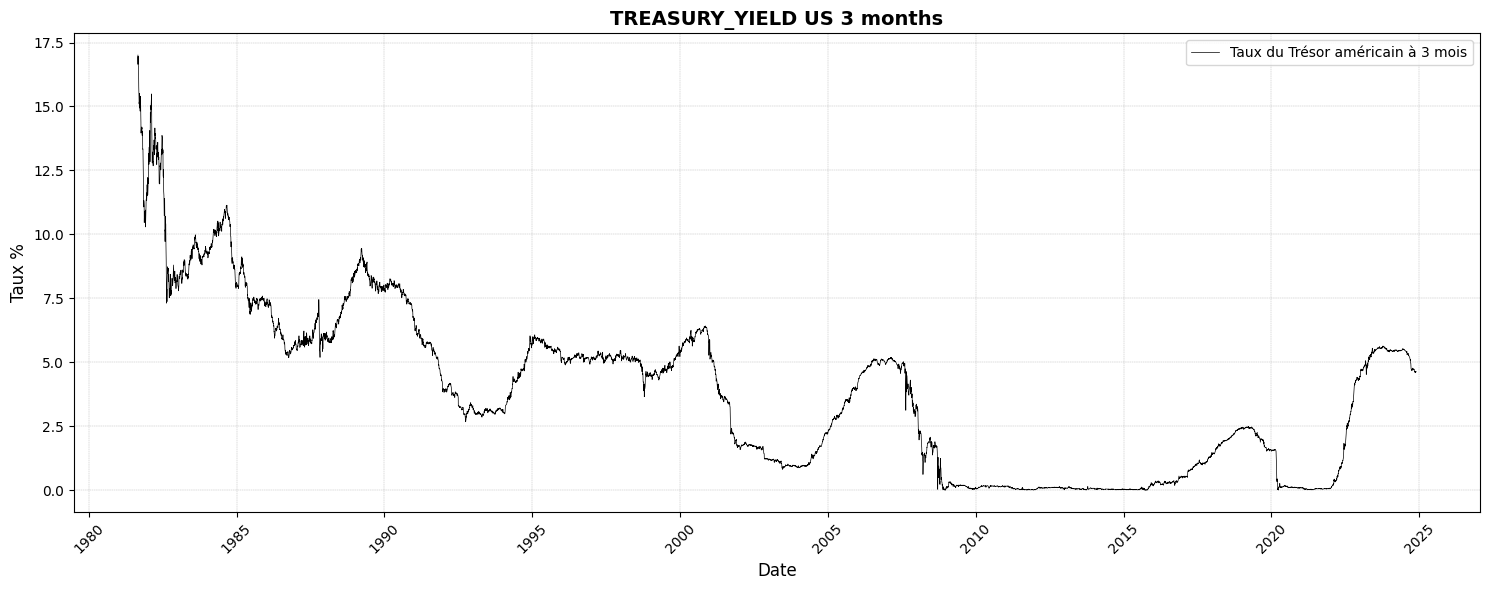

In [21]:
# Tracer la courbe des taux d'intérêt avec des améliorations esthétiques
plt.figure(figsize=(15, 6))
plt.plot(df_initial['date'], df_initial['value'], color='black', linewidth=0.5, linestyle='-', label='Taux du Trésor américain à 3 mois')

# Ajouter des labels et un titre
plt.xlabel('Date', fontsize=12)
plt.ylabel('Taux %', fontsize=12)
plt.title('TREASURY_YIELD US 3 months', fontsize=14, fontweight='bold')

# Améliorer la légende, la grille et le format de la date
plt.legend(loc="upper right", fontsize=10)
plt.grid(True, which='both', linestyle='--', linewidth=0.3)
plt.xticks(rotation=45)  # Rotation pour une meilleure lisibilité des dates
plt.tight_layout()  # Ajuste les marges pour éviter le chevauchement

plt.savefig("cour.png", dpi=300, bbox_inches="tight")

plt.show()

**Remarque :** A vue d'oeil, la période $2023 - 2025$ semble intéressante pour un ajustement.

On pourra également jouer sur la taille de l'historique $2021 / 2022$ par ex pour avoir une moyenne au long terme plus faible si besoin.

**Remarque :** La période semble ici vraiment idéale pour  l'ajustement d'un modèle CIR. On observe clairement une oscilation sur une période relativement étendu. (idéal pour simuler à plusieurs mois)

Contrairement au sous entendu de la question, ce n'est pas une solution de l'EDS (il y a pas de forme explicite). C'est une approximation d'une solution forte (dépend directement du mouvement brownien) par discrétisation d'Euler.

Il y a des choses à dire sur la solution qu'il essaie d'approcher, pour assurer l'existence et l'unicité d'une solution forte, il est nécessaire que les fonction drift et volatilité soient Lipshitz (Cf son cour chapitre 3). Ici la fonction $\sqrt{.}$ n'est pas Lipshitz mais le réultat peut s'étendre sous la condition de Feller. (Je sais pas si il faut forcement rentrer dans les détails)

**Réponse sûrement attendu :**

$$
dR_t = \alpha (\beta - R_t) \, dt + \sigma \sqrt{R_t} \, dB_t,
$$


En utilisant la méthode de discrétisation d’Euler-Maruyama :
   
$$
R_{t+h} \approx R_t + \alpha (\beta - R_t) h + \sigma \sqrt{R_t} \sqrt{h} Z,
$$  

où $ Z \sim \mathcal{N}(0, 1) $ est une variable aléatoire normale standard.

En simplifiant : 


$$
\frac{R_{t+h} - R_t}{\sqrt{R_t}} \approx \frac{\alpha (\beta - R_t) h + \sigma \sqrt{R_t} \sqrt{h} Z}{\sqrt{R_t}}.
$$



$$
\frac{R_{t+h} - R_t}{\sqrt{R_t}} \approx \alpha (\beta - R_t) \frac{h}{\sqrt{R_t}} + \sigma \sqrt{h} Z.
$$


**Réécriture de l'équation sous forme linéaire**

Équation de départ :

$$ \frac{R_{t+h} - R_t}{\sqrt{R_t}} = \alpha (\beta - R_t) \frac{h}{\sqrt{R_t}} + \sigma \sqrt{h} Z $$

Forme linéaire :

$$ y = \beta_1 x_{1} + \beta_2 x_{2} + u $$

Avec les correspondances suivantes :
- $ y = \frac{R_{t+h} - R_t}{\sqrt{R_t}} $
- $ \beta_1 = \alpha \beta $
- $ \beta_2 = -\alpha $
- $ x_{1} = \frac{h}{\sqrt{R_t}} $
- $ x_{2} = \sqrt{R_t}h $
- $ u = \sigma \sqrt{h} Z $, avec $ Z \sim \mathcal{N}(0, 1) $



Estimation des paramètres :

- **Estimation de $ \alpha $** :
$$ \hat{\alpha} = -\hat{\beta}_2 $$


- **Estimation de $ \beta $** :
$$ \hat{\beta} = \frac{\hat{\beta}_1}{\hat{\alpha}} $$


- **Estimation de $ \sigma^2 $** :
$$ \hat{\sigma}^2 = \frac{\text{Var}(\hat{u})}{h} $$

où $ \hat{\beta}_1 $ et $ \hat{\beta}_2 $ sont obtenus en régressant $ y $ sur $ x_{1} $ et $ x_{2} $, et la variance des résidus $ u $ permet d’estimer $ \sigma^2 $.


# Période Optimale :

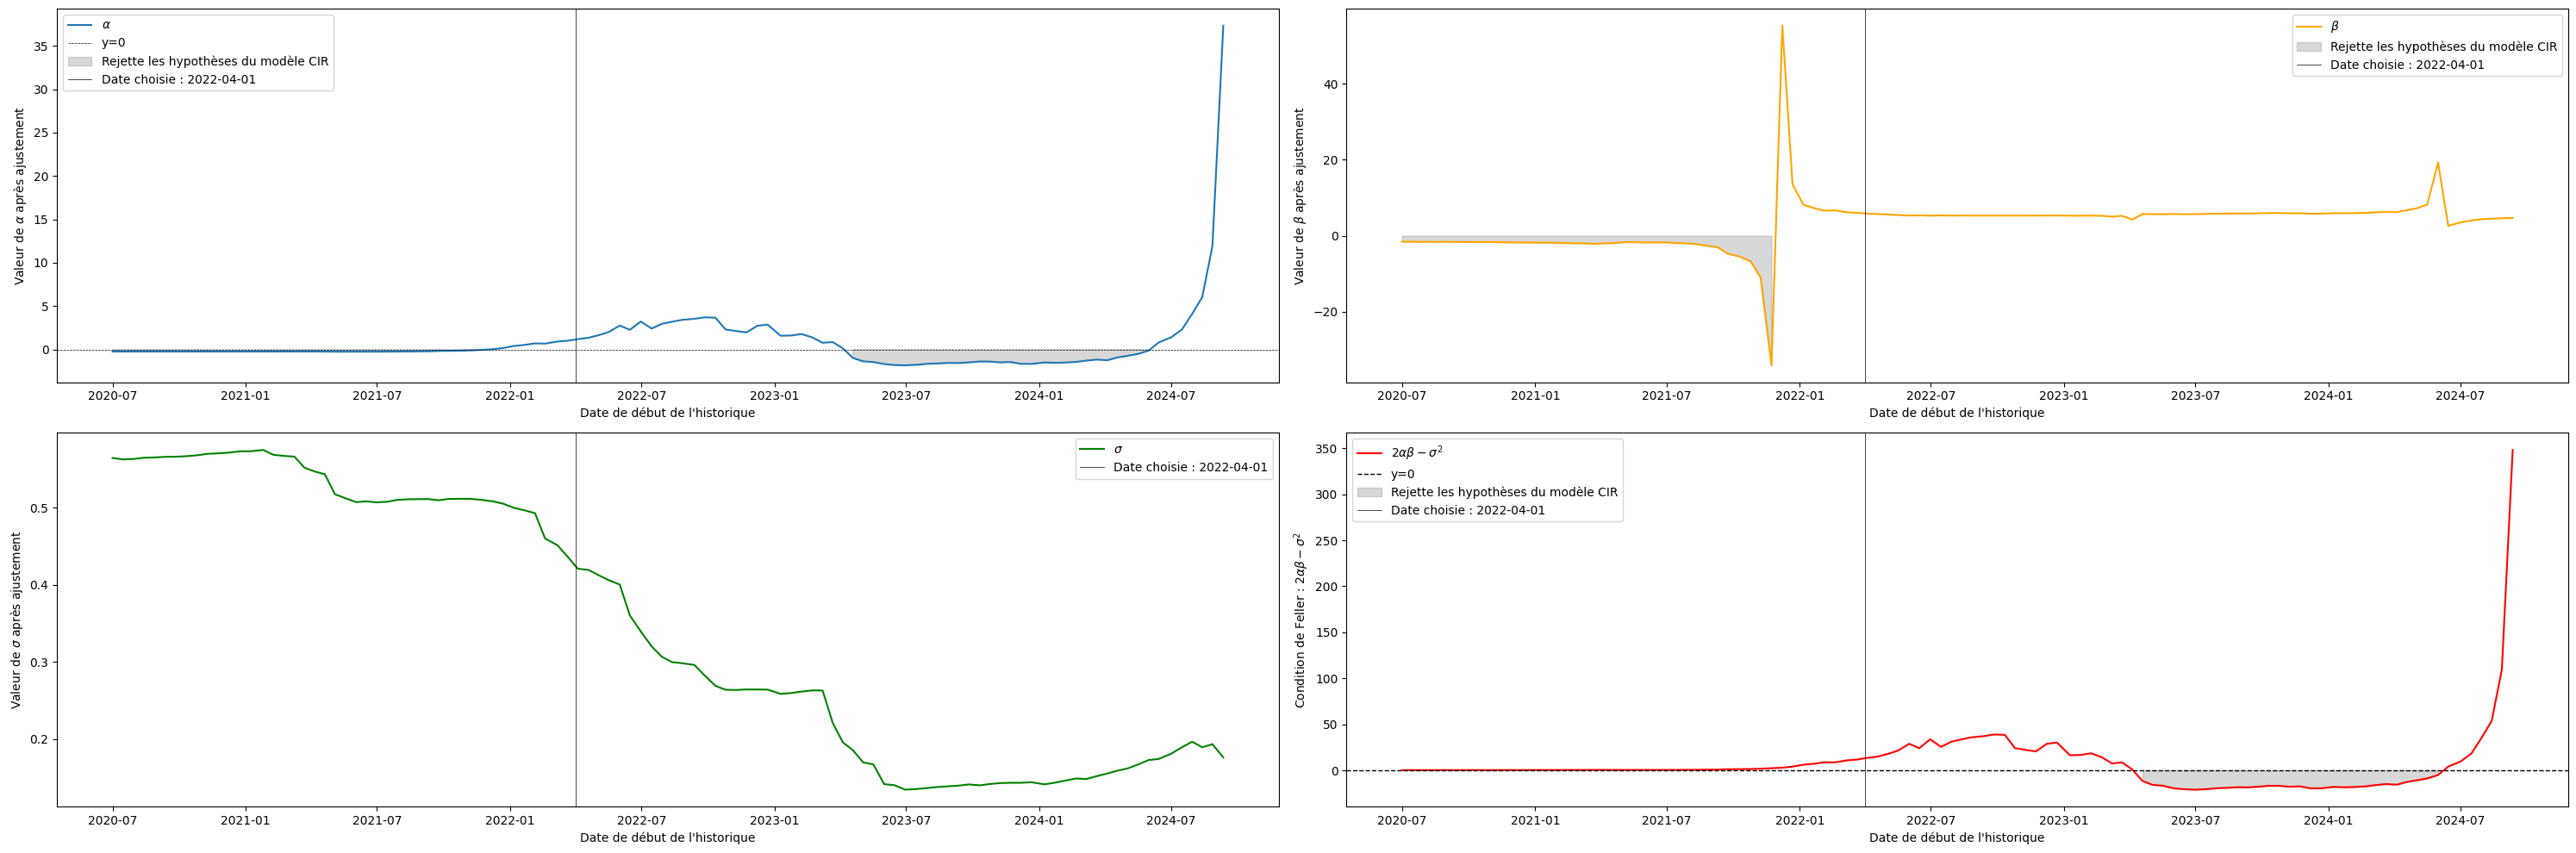

In [22]:
data = df_initial['value'].values  # Extraction des taux sous forme de tableau numpy
dates = pd.to_datetime(df_initial['date']).values  # Extraction des dates sous forme de tableau numpy

# Définir l'intervalle de temps pour les données journalières (base de 252 jours de bourse par an)
dt = 1 / 252

# Fonction ols_cir pour estimer les paramètres du modèle CIR
def ols_cir(data, dt):
    Nsteps = len(data)
    rs = data[:Nsteps - 1]  
    rt = data[1:Nsteps]
    
    y = (rt - rs) / np.sqrt(rs)
    z1 = dt / np.sqrt(rs)
    z2 = dt * np.sqrt(rs)
    X = np.column_stack((z1, z2))

    model = LinearRegression(fit_intercept=False)
    model.fit(X, y)

    y_hat = model.predict(X)
    residuals = y - y_hat
    beta1 = model.coef_[0]        
    beta2 = model.coef_[1]

    α = -beta2
    β = beta1 / α
    σ = np.std(residuals) / np.sqrt(dt)
    
    return α, β, σ

# Fonction pour calculer l'évolution des paramètres en fonction de la taille de l'historique
def track_parameter_evolution(data, dates, dt, min_history=50, max_history=None, step=10):
    if max_history is None:
        max_history = len(data)
    
    results = {
        "history_size": [],
        "start_date": [],
        "alpha": [],
        "beta": [],
        "sigma": [],
        "feller_condition": []
    }

    for n in range(min_history, max_history + 1, step):
        data_subset = data[-n:]
        start_date = dates[-n]

        α, β, σ = ols_cir(data_subset, dt)
        
        feller_condition = 2 * α * β - σ**2
        
        results["history_size"].append(n)
        results["start_date"].append(start_date)
        results["alpha"].append(α)
        results["beta"].append(β)
        results["sigma"].append(σ)
        results["feller_condition"].append(feller_condition)

    return pd.DataFrame(results)

# Paramètres pour la taille de l'historique
min_history = 50
max_history = 1100
step = 10

# Calculer l'évolution des paramètres
evolution_df = track_parameter_evolution(data, dates, dt, min_history, max_history, step)

# Date choisie pour la ligne verticale
date_choisie = pd.to_datetime("2022-04-01")

# Visualiser les résultats en une grille 2x2
fig, axs = plt.subplots(2, 2, figsize=(30, 10))

# Graphique de l'évolution de α avec la ligne y=0 et ligne verticale
axs[0, 0].plot(evolution_df["start_date"], evolution_df["alpha"], label=r"$\alpha$", linewidth=1.5)
axs[0, 0].axhline(0, color="black", linestyle="--", linewidth=0.5, label="y=0")
axs[0, 0].fill_between(evolution_df["start_date"], evolution_df["alpha"], where=(evolution_df["alpha"] < 0),
                       color="grey", alpha=0.3, label="Rejette les hypothèses du modèle CIR")
axs[0, 0].axvline(date_choisie, color="black", linestyle="-", linewidth=0.5, label="Date choisie : 2022-04-01")
axs[0, 0].set_xlabel("Date de début de l'historique")
axs[0, 0].set_ylabel(r"Valeur de $\alpha$ après ajustement")
axs[0, 0].legend()

# Graphique de l'évolution de β avec zone grise pour les valeurs négatives
axs[0, 1].plot(evolution_df["start_date"], evolution_df["beta"], label=r"$\beta$", color="orange", linewidth=1.5)
axs[0, 1].fill_between(evolution_df["start_date"], evolution_df["beta"], where=(evolution_df["beta"] < 0),
                       color="grey", alpha=0.3, label="Rejette les hypothèses du modèle CIR")
axs[0, 1].axvline(date_choisie, color="black", linestyle="-", linewidth=0.5, label="Date choisie : 2022-04-01")  # Ligne verticale
axs[0, 1].set_xlabel("Date de début de l'historique")
axs[0, 1].set_ylabel(r"Valeur de $\beta$ après ajustement")
axs[0, 1].legend()

# Graphique de l'évolution de σ avec ligne verticale et légende
axs[1, 0].plot(evolution_df["start_date"], evolution_df["sigma"], label=r"$\sigma$", color="green", linewidth=1.5)
axs[1, 0].axvline(date_choisie, color="black", linestyle="-", linewidth=0.5, label="Date choisie : 2022-04-01")
axs[1, 0].set_xlabel("Date de début de l'historique")
axs[1, 0].set_ylabel(r"Valeur de $\sigma$ après ajustement")
axs[1, 0].legend()

# Graphique de la condition de Feller avec la ligne y=0 et ligne verticale
axs[1, 1].plot(evolution_df["start_date"], evolution_df["feller_condition"], label=r"$2 \alpha \beta - \sigma^2$", color="red", linewidth=1.5)
axs[1, 1].axhline(0, color="black", linestyle="--", linewidth=1, label="y=0")
axs[1, 1].fill_between(evolution_df["start_date"], evolution_df["feller_condition"], where=(evolution_df["feller_condition"] < 0),
                       color="grey", alpha=0.3, label="Rejette les hypothèses du modèle CIR")
axs[1, 1].axvline(date_choisie, color="black", linestyle="-", linewidth=0.5, label="Date choisie : 2022-04-01")
axs[1, 1].set_xlabel("Date de début de l'historique")
axs[1, 1].set_ylabel(r"Condition de Feller : $2 \alpha \beta - \sigma^2$")
axs[1, 1].legend()

# Sauvegarder le graphique en haute qualité
plt.savefig("evolution_parametres_cir.png", dpi=300, bbox_inches="tight")
plt.tight_layout()
plt.show()

**Remarque :** Cette étape n'était pas demandée, mais elle était nécessaire pour réaliser rigoureusement la suite du projet.
La période 2020-2022 est problématique pour l'ajustement d'un modèle CIR. Le taux était proche de zéro, et au-delà des problèmes informatiques, les hypothèses du modèle ne sont pas respectées.

On verra par la suite que la période choisie présente également des défauts, dont le plus important est que la moyenne à long terme est légèrement élevée.

Nous avons cependant conclu que choquer un portefeuille par une hausse de taux est pertinent dans certains contextes (même si, en général, cela se fait de façon déterministe), et que ce défaut peut être considéré comme faisant parti des limites du modèle.

# Etude de l'ajustement sur la période choisie

/var/folders/28/1h3z3mcs1gxg23mnjw1zj_n00000gn/T/ipykernel_18213/1651928769.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



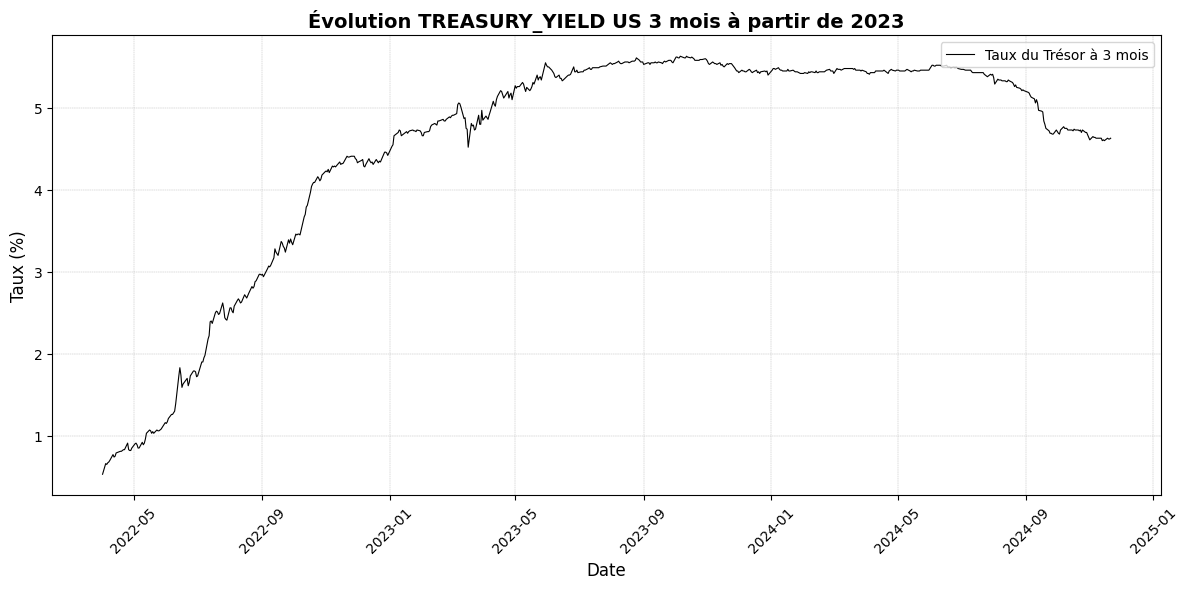

In [23]:
# Filtrer le DataFrame pour ne conserver que les dates à partir de 2023
df = df_initial[df_initial['date'] >= '2022 -04-01']

# Remplace toutes les valeurs de 'value' par leur valeur absolue
df['value'] = df['value'].abs()

# Supprimer les lignes avec des valeurs manquantes ou non numériques dans la colonne 'value'
df = df[df['value'] != '.']

# Convertir la colonne de taux d'intérêt en float
df['value'] = df['value'].astype(float)

# Trier les données par date
df = df.sort_values(by='date')

# Tracer la courbe des taux d'intérêt avec des améliorations esthétiques
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['value'], color='black', linewidth=0.8, linestyle='-', label='Taux du Trésor à 3 mois')

# Ajouter des labels et un titre
plt.xlabel('Date', fontsize=12)
plt.ylabel('Taux (%)', fontsize=12)
plt.title("Évolution TREASURY_YIELD US 3 mois à partir de 2023", fontsize=14, fontweight='bold')

# Améliorer la légende, la grille et le format de la date
plt.legend(loc="upper right", fontsize=10)
plt.grid(True, which='both', linestyle='--', linewidth=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

# Afficher le graphique
plt.show()

### Remarque :

Mes données sont journalières donc je prend $h = \frac{1}{252}$, mais c'est un choix qui peut être discutable. Pour plus de rigueur, on peut poser des fonctions qui dépendent de h.

On doit construire :

$$
M = \begin{bmatrix}
r_2 - r_1 & r_1 & \frac{1}{252} \\
r_3 - r_2 & r_2 & \frac{1}{252} \\
r_4 - r_3 & r_3 & \frac{1}{252} \\
\vdots & \vdots & \vdots \\
r_n - r_{n-1} & r_{n-1} & \frac{1}{252} \\
\end{bmatrix}
$$

In [24]:
# Extraire la colonne 'clot' pour obtenir les taux sans risque
taux_sans_risque = df['value'].values

# Construire la matrice M
M = np.array([[taux_sans_risque[i] - taux_sans_risque[i - 1], taux_sans_risque[i - 1], 1/252] 
              for i in range(1, len(taux_sans_risque))])

# Afficher la matrice M
print(M[:5])

[[ 0.13        0.53        0.00396825]
 [-0.01        0.66        0.00396825]
 [ 0.02        0.65        0.00396825]
 [ 0.01        0.67        0.00396825]
 [ 0.02        0.68        0.00396825]]


# Fonction régression :

In [25]:
# Fonction ols_cir pour estimer les paramètres du modèle CIR
def ols_cir(data, dt):
    Nsteps = len(data)
    rs = data[:Nsteps - 1]  
    rt = data[1:Nsteps]
    
    y = (rt - rs) / np.sqrt(rs)
    z1 = dt / np.sqrt(rs)
    z2 = dt * np.sqrt(rs)
    X = np.column_stack((z1, z2))

    model = LinearRegression(fit_intercept=False)
    model.fit(X, y)

    y_hat = model.predict(X)
    residuals = y - y_hat
    beta1 = model.coef_[0]        
    beta2 = model.coef_[1]

    α = -beta2
    β = beta1 / α
    σ = np.std(residuals) / np.sqrt(dt)
    
    return α, β, σ

##  Résultat régression :

In [26]:
data = df_initial['value'].values  # Extraction des taux sous forme de tableau numpy
dates = pd.to_datetime(df_initial['date']).values  # Extraction des dates sous forme de tableau numpy

# Convertir la date choisie
date_choisie = pd.to_datetime("2022-04-01")

# Filtrer les données à partir de la date choisie jusqu'à la fin du DataFrame
mask = dates >= date_choisie
data_subset = data[mask]
dates_subset = dates[mask]

# Définir l'intervalle de temps
dt = 1 / 252

# Fonction ols_cir pour estimer les paramètres du modèle CIR sans intercept
def super_ols_cir(data, dt):
    Nsteps = len(data)
    rs = data[:Nsteps - 1]  
    rt = data[1:Nsteps]
    
    # Création des variables explicatives
    y = (rt - rs) / np.sqrt(rs)
    x1 = dt / np.sqrt(rs)
    x2 = dt * np.sqrt(rs)
    X = np.column_stack((x1, x2))  # Matrice des variables explicatives sans constante

    # Modèle de régression linéaire sans intercept
    model = sm.OLS(y, X).fit()
    
    # Calcul des résidus et des prédictions
    residuals = model.resid
    predictions = model.predict(X)
    beta_1, beta_2 = model.params  # Extraire les coefficients de régression
    
    return model, beta_1, beta_2, residuals, x1, x2, y

# Effectuer la régression à partir de la date choisie jusqu'à la fin
model, beta_1, beta_2, residuals, x1, x2, y = super_ols_cir(data_subset, dt)

# Créer un espace de valeurs pour x1 et x2 pour tracer le plan de régression
x1_grid, x2_grid = np.meshgrid(np.linspace(min(x1), max(x1), 20),
                               np.linspace(min(x2), max(x2), 20))

# Calculer les valeurs prédites de y sur le plan de régression sans constante
y_pred = beta_1 * x1_grid + beta_2 * x2_grid

# Résultats détaillés du modèle
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.094
Model:                            OLS   Adj. R-squared (uncentered):              0.091
Method:                 Least Squares   F-statistic:                              33.94
Date:                Sat, 23 Nov 2024   Prob (F-statistic):                    9.38e-15
Time:                        14:11:02   Log-Likelihood:                          1445.5
No. Observations:                 660   AIC:                                     -2887.
Df Residuals:                     658   BIC:                                     -2878.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

**Remarque :** D'un point de vue statistique, les résultats donnés par la régression semble convenables. (Les variables sont bien significatives ..)

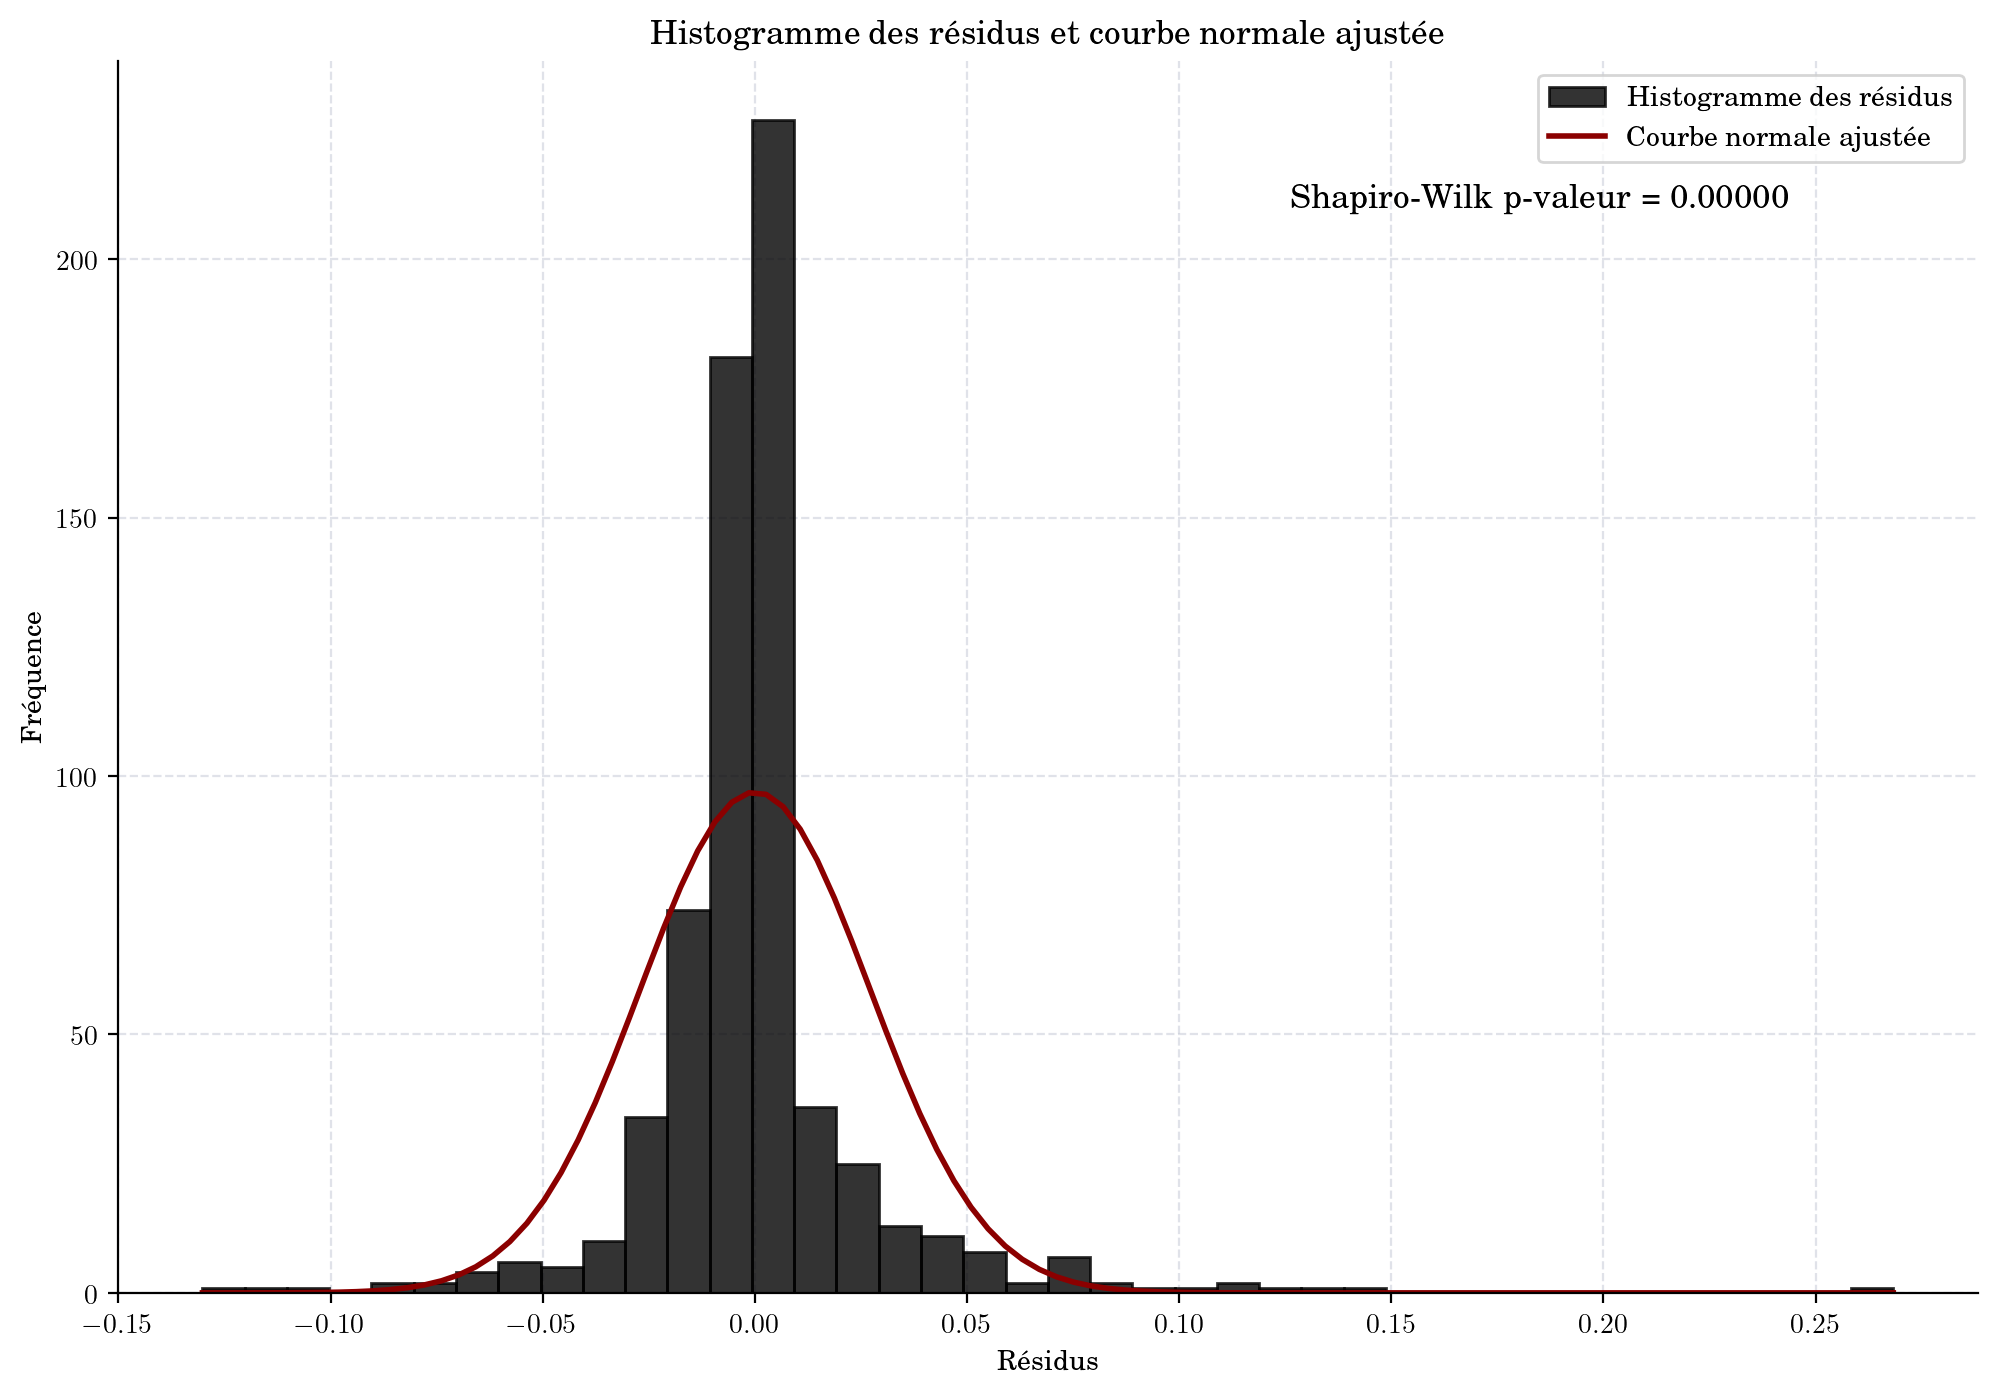

In [73]:
# Test de Shapiro-Wilk pour la normalité des résidus
shapiro_stat, shapiro_p_value = shapiro(residuals)

# Préparation des données pour l'histogramme avec plus de colonnes (par exemple, 40 bins)
hist_data = np.histogram(residuals, bins=40)

# Calcul de la courbe d'ajustement normale (loi normale)
mu, std = np.mean(residuals), np.std(residuals)
x_vals = np.linspace(residuals.min(), residuals.max(), 100)
normal_fit = norm.pdf(x_vals, mu, std) * len(residuals) * (hist_data[1][1] - hist_data[1][0])

# Création du graphique
plt.figure(figsize=(12, 8))

# Histogramme des résidus
plt.hist(residuals, bins=40, alpha=0.8, color='black', edgecolor='black', label='Histogramme des résidus')

# Courbe d'ajustement normale
plt.plot(x_vals, normal_fit, color='darkred', lw=2, label='Courbe normale ajustée')

# Texte pour l'annotation du test de Shapiro-Wilk
annotation_text = f"Shapiro-Wilk p-valeur = {shapiro_p_value:.5f}"

# Ajouter le texte d'annotation sur le graphique
plt.text(0.9, 0.9, annotation_text, fontsize=12, color="black", transform=plt.gca().transAxes,
         horizontalalignment='right', verticalalignment='top')

# Labels des axes et titre
plt.xlabel("Résidus")
plt.ylabel("Fréquence")
plt.title("Histogramme des résidus et courbe normale ajustée")

# Ajouter une légende
plt.legend()

# Afficher le graphique
plt.show()

**Remarque :** Les résidus sont bien centrés en 0 et l'hypothèse de normalité semble justifiable. Malheureusement, les tests de normalité rejettent l'hypothèse car les queues sont légèrement épaisses et que le nombre d'observation est très important.

### Paramètres initiaux :

In [37]:
# Extraire les coefficients estimés
beta_1_hat, beta_2_hat = model.params

# Estimation de alpha
alpha_hat = -beta_2_hat

# Estimation de beta
beta_hat = beta_1_hat / alpha_hat

# Estimation de sigma^2
h = 1/252
sigma2_hat = np.var(residuals) / h

# Affichage des résultats
print("Estimation des paramètres :")
print(f"alpha_hat = {alpha_hat}")
print(f"beta_hat = {beta_hat}")
print(f"sigma2_hat = {sigma2_hat}")
print(f"sigma_hat(utilisé dans la formule) = {np.sqrt(sigma2_hat)}")

Estimation des paramètres :
alpha_hat = 1.3977920268924613
beta_hat = 5.65819053908096
sigma2_hat = 0.18472501999358557
sigma_hat(utilisé dans la formule) = 0.42979648671619636


### Condition de Feller :

$$ 2 \alpha \beta \geq \sigma^2 $$

In [38]:
# Calcul de sigma à partir de sigma^2
sigma_hat = np.sqrt(sigma2_hat)

# Calcul de 2 * alpha * beta
feller_condition = 2 * alpha_hat * beta_hat

# Vérification de la condition de Feller
if feller_condition >= sigma_hat**2:
    print("La condition de Feller est satisfaite : 2 * alpha * beta >= sigma^2")
else:
    print("La condition de Feller n'est PAS satisfaite : 2 * alpha * beta < sigma^2")

# Affichage des valeurs calculées
print(f"2 * alpha_hat * beta_hat = {feller_condition}")
print(f"sigma_hat^2 = {sigma_hat**2}")

La condition de Feller est satisfaite : 2 * alpha * beta >= sigma^2
2 * alpha_hat * beta_hat = 15.817947244331446
sigma_hat^2 = 0.18472501999358557


$$
\begin{cases}
    \mathrm{d}R_t = \alpha (\beta - R_t) \, \mathrm{d}t + \sigma \sqrt{\max(0, R_t)} \, \mathrm{d}B_t, \\
    R_0 = r_0,
\end{cases}
$$

### Remarque : 

Il s'agit exactement du même modèle avec une légède condition. Dans le cas continue, notre taux atteint 0 presque surement jamais (Feller) mais dans le cas d'une discrétisation (propriétés pont brownien ....), il exite une probabilité positive que ça arrive. On rajoute un max avec 0 pour éviter toute sorte d'erreur, surtout dans les périodes de forte volatilité.

In [40]:
historical_values = df['value'].values

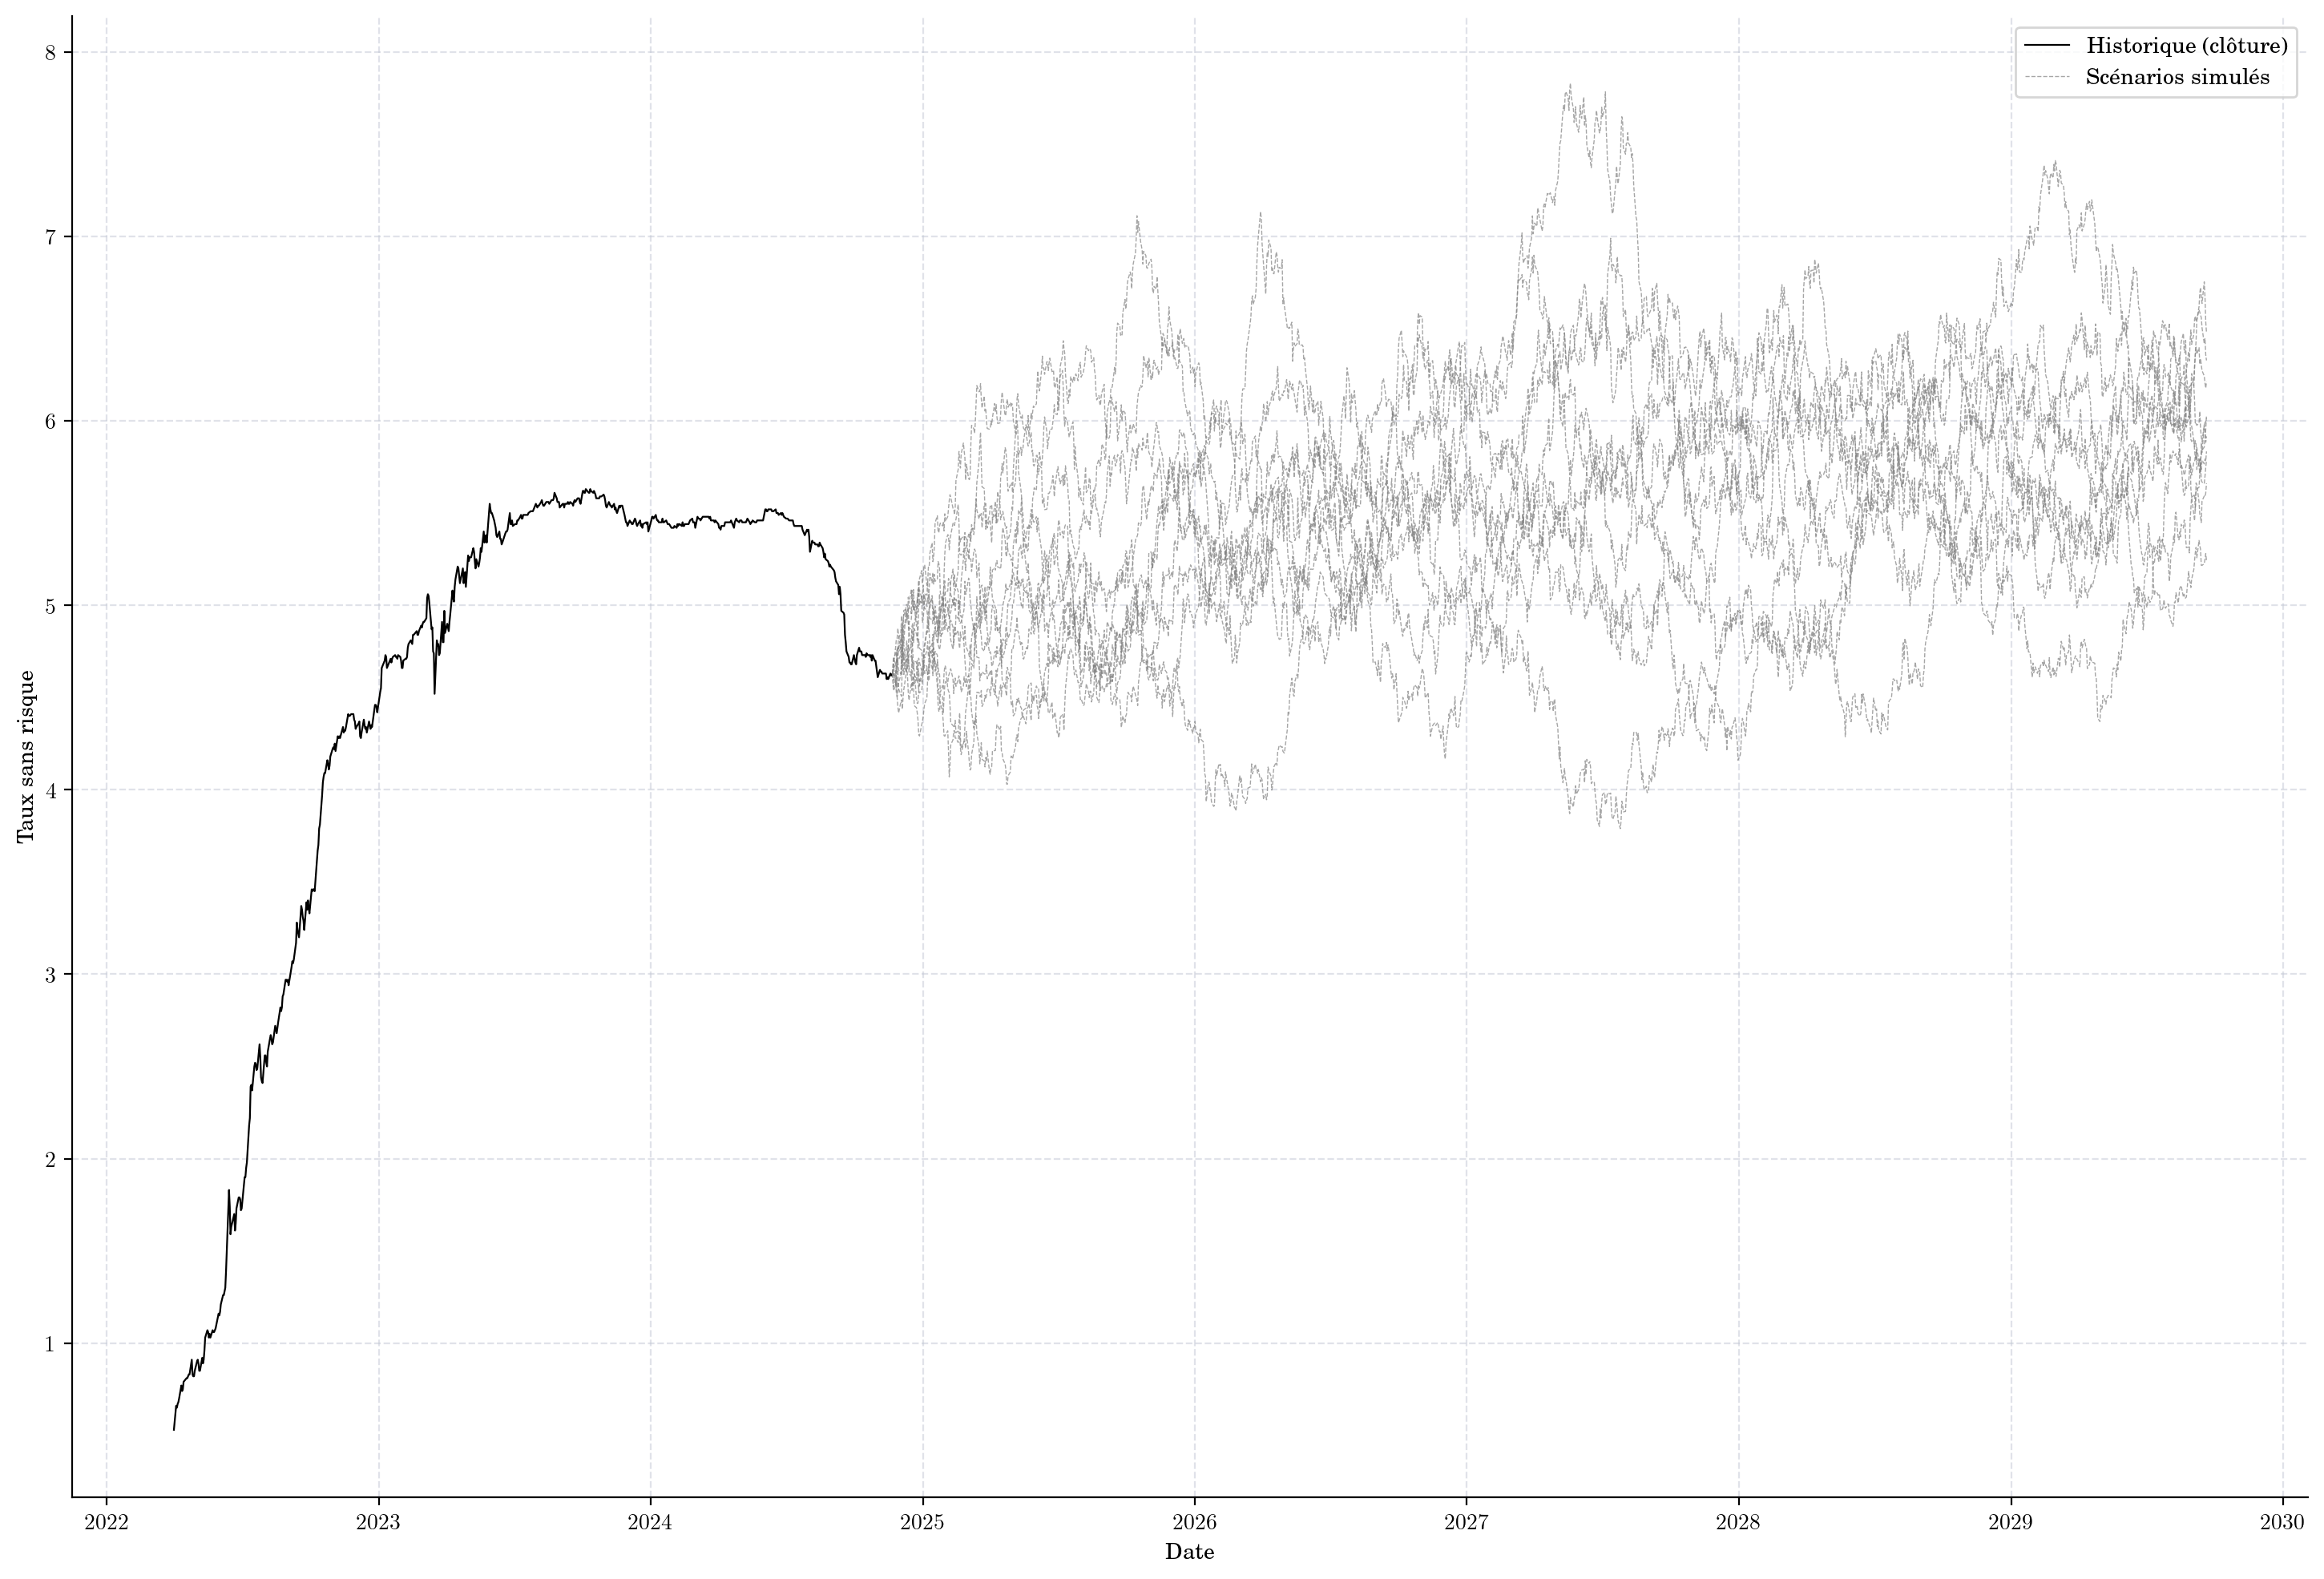

In [46]:
# `df_initial` est le DataFrame d'origine avec les colonnes 'date' et 'value'
dates = pd.to_datetime(df_initial['date'])  # Conversion de la colonne 'date' en format datetime
historical_values = df_initial['value'].values  # Extraction des valeurs historiques en tableau numpy

# Convertir la date choisie
date_choisie = pd.to_datetime("2022-04-01")

# Filtrer les données à partir de la date choisie jusqu'à la fin du DataFrame
mask = dates >= date_choisie
dates = dates[mask]
historical_values = historical_values[mask]  # Application du masque de même longueur sur les deux tableaux

# Calcul des paramètres du modèle CIR (estimés précédemment)
alpha = -beta_2
beta = beta_1 / alpha
sigma = np.std(residuals) / np.sqrt(dt)

# Dernière valeur historique comme point de départ pour la simulation
r_0 = historical_values[-1]

# Paramètres de simulation
n_scenarios = 10      # Nombre de scénarios à simuler
n_steps = 252 * 5     # Nombre de pas pour 5 ans de simulation (252 jours ouvrés par an)
dt = 1 / 252          # Taille de chaque pas (un jour ouvré)

# Initialisation des trajectoires
scenarios = np.zeros((n_steps + 1, n_scenarios))
scenarios[0] = r_0  # Chaque scénario commence à la dernière valeur historique

# Génération des scénarios de simulation
for i in range(1, n_steps + 1):
    # Calcul des termes de drift et de diffusion
    drift = alpha * (beta - scenarios[i - 1])
    diffusion = sigma * np.sqrt(np.maximum(scenarios[i - 1], 0)) * np.random.normal(size=n_scenarios)
    # Application de la méthode d'Euler pour calculer la prochaine valeur
    scenarios[i] = scenarios[i - 1] + drift * dt + diffusion * np.sqrt(dt)

# Tracé des données historiques en noir
plt.figure(figsize=(18, 12))
plt.plot(dates, historical_values, lw=0.8, label="Historique (clôture)", color='black')

# Étendre les dates pour les scénarios simulés
last_date = dates.iloc[-1]  # Dernière date des données historiques
future_dates = pd.date_range(last_date, periods=n_steps + 1, freq='B')  # 'B' pour jours ouvrés

# Tracé des scénarios simulés
for j in range(n_scenarios):
    plt.plot(future_dates, scenarios[:, j], lw=0.5, linestyle='--', color='gray', alpha=0.7,
             label='Scénarios simulés' if j == 0 else "")

# Paramètres du graphique
plt.xlabel("Date")
plt.ylabel("Taux sans risque")
plt.legend()
plt.savefig("scenarios.png", dpi=300, bbox_inches='tight')
plt.show()

**Remarque :** L'ajustement semble plutôt satisfaisant.

## Moyenne 2 ans

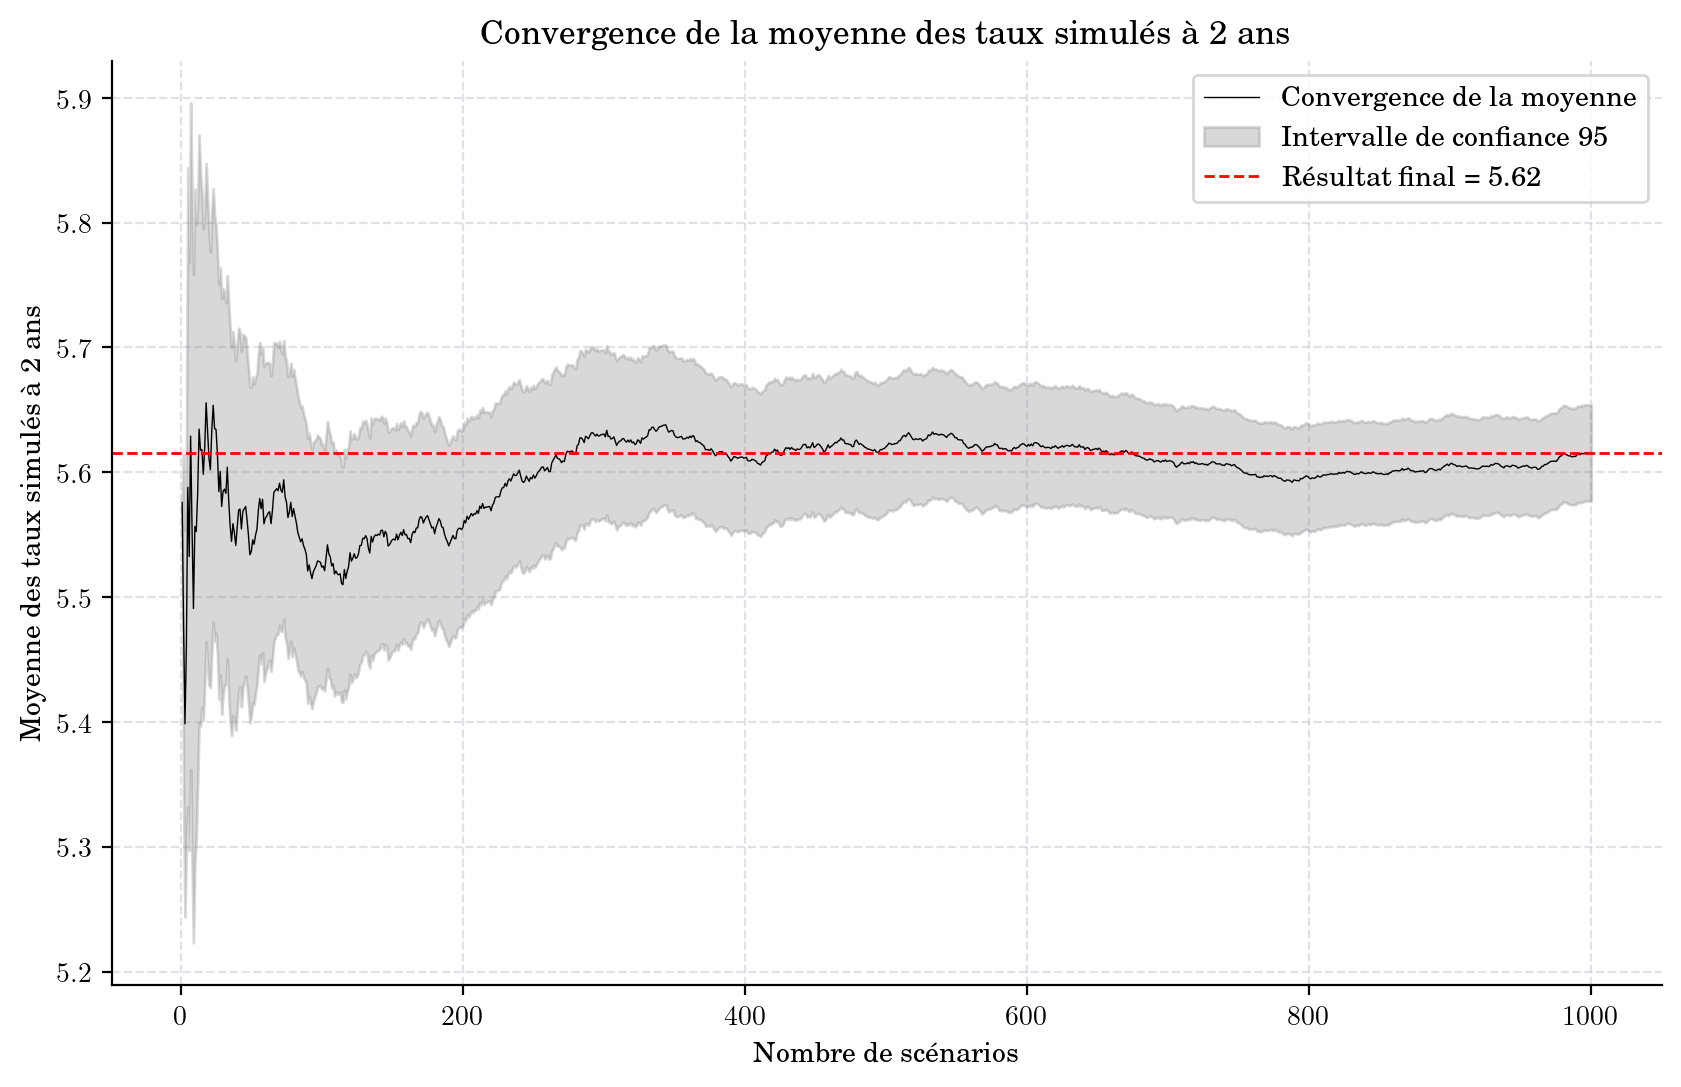

In [48]:
dates = pd.to_datetime(df_initial['date'])  # Conversion de la colonne 'date' en format datetime
historical_values = df_initial['value'].values  # Extraction des valeurs historiques en tableau numpy

# Convertir la date choisie
date_choisie = pd.to_datetime("2022-04-01")

# Filtrer les données à partir de la date choisie jusqu'à la fin du DataFrame
mask = dates >= date_choisie
dates = dates[mask]
historical_values = historical_values[mask]  # Application du masque de même longueur sur les deux tableaux

# Calcul des paramètres du modèle CIR (estimés précédemment)
alpha = -beta_2
beta = beta_1 / alpha
sigma = np.std(residuals) / np.sqrt(dt)

# Dernière valeur historique comme point de départ pour la simulation
r_0 = historical_values[-1]

# Paramètres de simulation
n_scenarios = 1000   # Nombre maximum de scénarios pour la convergence
n_steps = 252 * 2    # Nombre de pas pour 2 ans de simulation (252 jours ouvrés par an)
dt = 1 / 252         # Taille de chaque pas (un jour ouvré)

# Fonction de simulation Monte Carlo pour le modèle CIR
def simulate_cir(alpha, beta, sigma, r0, n_steps, n_scenarios):
    paths = np.zeros((n_steps + 1, n_scenarios))
    paths[0] = r0

    for i in range(1, n_steps + 1):
        drift = alpha * (beta - paths[i - 1])
        diffusion = sigma * np.sqrt(np.maximum(paths[i - 1], 0)) * np.random.normal(size=n_scenarios)
        paths[i] = paths[i - 1] + drift * dt + diffusion * np.sqrt(dt)
    
    return paths

# Simuler les trajectoires
scenarios = simulate_cir(alpha, beta, sigma, r_0, n_steps, n_scenarios)

# Calcul de la convergence de la moyenne et de l'intervalle de confiance
convergence_means = []
confidence_intervals = []
for i in range(1, n_scenarios + 1):
    mean_2_years = np.mean(scenarios[n_steps, :i])  # Moyenne à 2 ans pour les i premiers scénarios
    convergence_means.append(mean_2_years)
    
    # Calcul de l'intervalle de confiance (écart-type / sqrt(n) pour la moyenne cumulée)
    std_error = np.std(scenarios[n_steps, :i]) / np.sqrt(i)
    confidence_intervals.append(1.96 * std_error)  # Intervalle de confiance à 95%

# Obtenir la moyenne finale avec 3 chiffres significatifs
final_mean = convergence_means[-1]
final_mean_formatted = f"{final_mean:.3g}"

# Tracer le graphe de convergence avec intervalle de confiance
plt.figure(figsize=(10, 6))

# Courbe de convergence de la moyenne
plt.plot(range(1, n_scenarios + 1), convergence_means, label="Convergence de la moyenne", color="black", linewidth=0.5)

# Intervalle de confiance autour de la moyenne
upper_bound = [m + ci for m, ci in zip(convergence_means, confidence_intervals)]
lower_bound = [m - ci for m, ci in zip(convergence_means, confidence_intervals)]
plt.fill_between(range(1, n_scenarios + 1), lower_bound, upper_bound, color='gray', alpha=0.3, label="Intervalle de confiance 95%")

# Ligne de la moyenne finale avec la valeur formatée dans la légende
plt.axhline(final_mean, color='red', linestyle="--", linewidth=1, label=f"Résultat final = {final_mean_formatted}")

# Paramètres du graphique
plt.xlabel("Nombre de scénarios")
plt.ylabel("Moyenne des taux simulés à 2 ans")
plt.title("Convergence de la moyenne des taux simulés à 2 ans")
plt.legend()

# Sauvegarde en haute résolution
plt.savefig("convergence_moyenne_2ans.png", dpi=300, bbox_inches='tight')
plt.show()

# Formules fermées :

## Espérance conditionnelle du processus CIR :

Pour $t > s$ et $R_s = r$ :

$$E[R_t | R_s = r] = θ + (r - θ) * exp(-κ * (t - s))$$

In [49]:
# Paramètres estimés et dernière valeur historique
alpha = -beta_2
beta = beta_1 / alpha
sigma = np.std(residuals) / np.sqrt(dt)
r_0 = historical_values[-1]
T = 2  # Horizon de 2 ans

# Calcul de l'espérance théorique avec la formule fermée
expected_r_T = beta + (r_0 - beta) * np.exp(-alpha * T)

# Moyenne obtenue par simulation
simulated_mean_2_years = np.mean(scenarios[n_steps])

# Affichage des résultats
print(f"Espérance théorique à 2 ans : {expected_r_T:.4f}")
print(f"Moyenne simulée à 2 ans : {simulated_mean_2_years:.4f}")

Espérance théorique à 2 ans : 5.5954
Moyenne simulée à 2 ans : 5.6152


## Moyenne 5 ans :

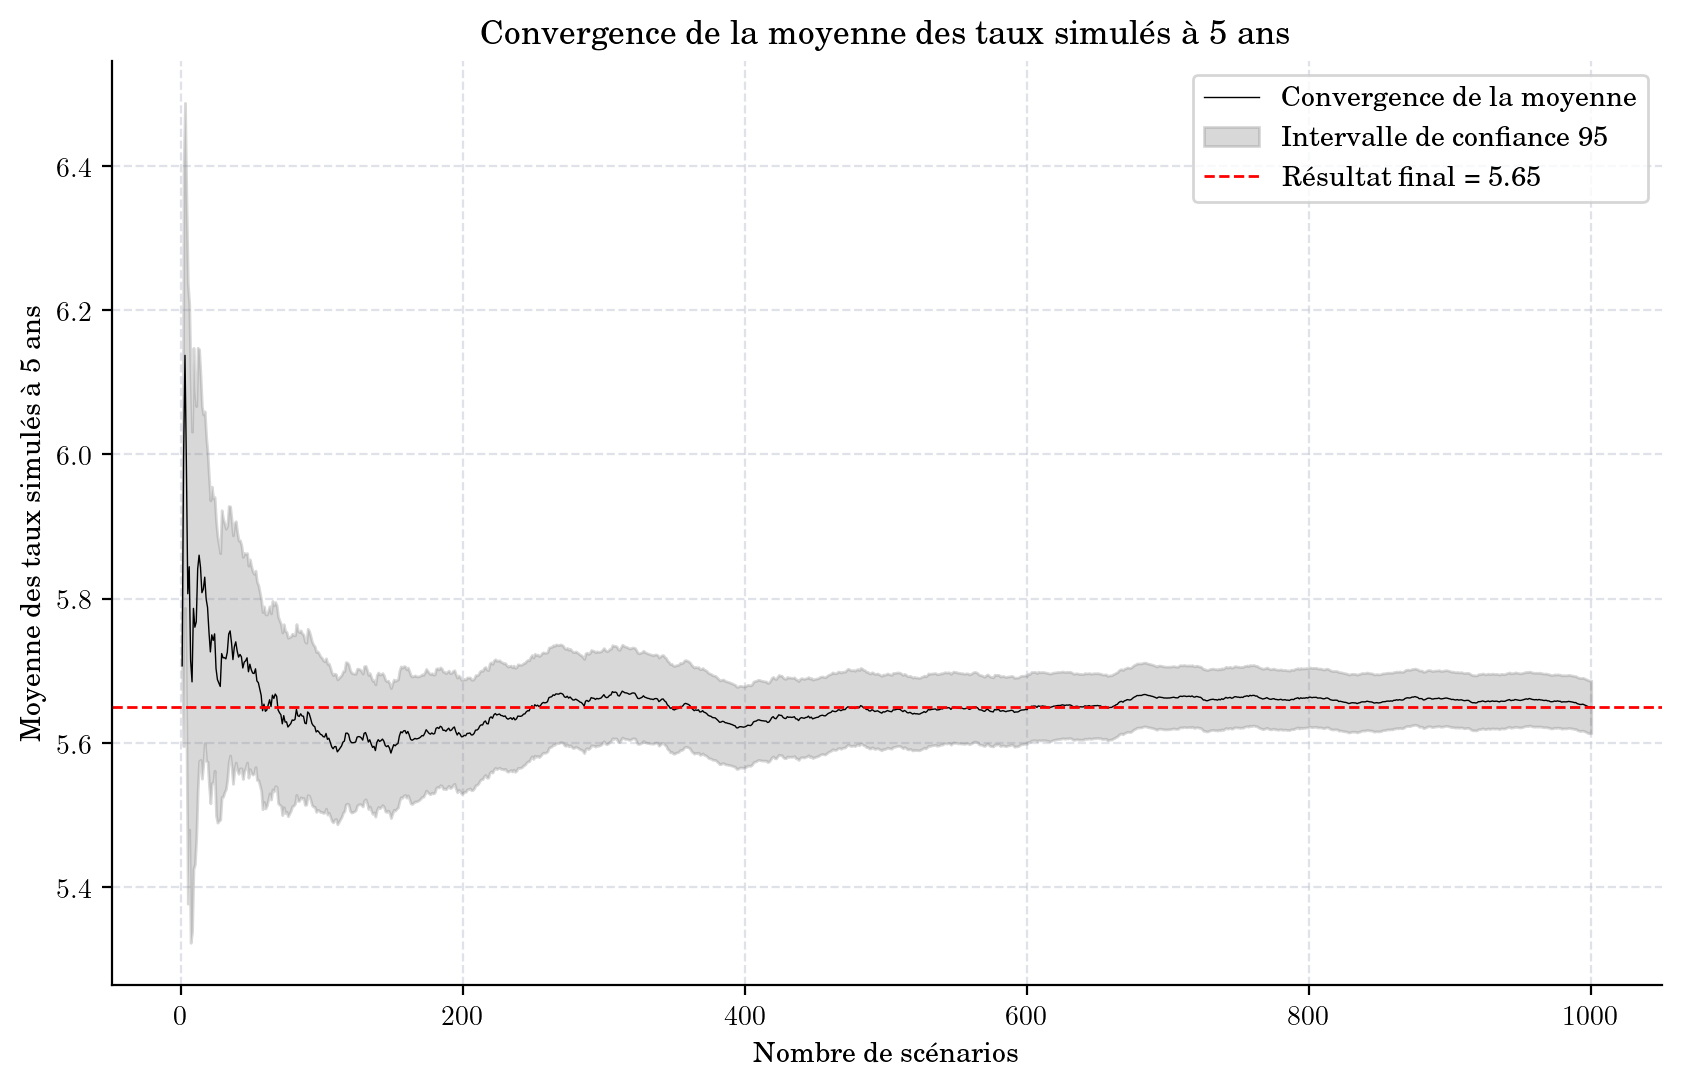

In [50]:
# `df_initial` est le DataFrame d'origine avec les colonnes 'date' et 'value'
dates = pd.to_datetime(df_initial['date'])  # Conversion de la colonne 'date' en format datetime
historical_values = df_initial['value'].values  # Extraction des valeurs historiques en tableau numpy

# Convertir la date choisie
date_choisie = pd.to_datetime("2022-04-01")

# Filtrer les données à partir de la date choisie jusqu'à la fin du DataFrame
mask = dates >= date_choisie
dates = dates[mask]
historical_values = historical_values[mask]  # Application du masque de même longueur sur les deux tableaux

# Calcul des paramètres du modèle CIR (estimés précédemment)
alpha = -beta_2
beta = beta_1 / alpha
sigma = np.std(residuals) / np.sqrt(dt)

# Dernière valeur historique comme point de départ pour la simulation
r_0 = historical_values[-1]

# Paramètres de simulation pour un horizon de 5 ans
n_scenarios = 1000    # Nombre maximum de scénarios pour la convergence
n_steps = 252 * 5     # Nombre de pas pour 5 ans de simulation (252 jours ouvrés par an)
dt = 1 / 252          # Taille de chaque pas (un jour ouvré)

# Fonction de simulation Monte Carlo pour le modèle CIR
def simulate_cir(alpha, beta, sigma, r0, n_steps, n_scenarios):
    paths = np.zeros((n_steps + 1, n_scenarios))
    paths[0] = r0

    for i in range(1, n_steps + 1):
        drift = alpha * (beta - paths[i - 1])
        diffusion = sigma * np.sqrt(np.maximum(paths[i - 1], 0)) * np.random.normal(size=n_scenarios)
        paths[i] = paths[i - 1] + drift * dt + diffusion * np.sqrt(dt)
    
    return paths

# Simuler les trajectoires pour un horizon de 5 ans
scenarios = simulate_cir(alpha, beta, sigma, r_0, n_steps, n_scenarios)

# Calcul de la convergence de la moyenne et de l'intervalle de confiance
convergence_means = []
confidence_intervals = []
for i in range(1, n_scenarios + 1):
    mean_5_years = np.mean(scenarios[n_steps, :i])  # Moyenne à 5 ans pour les i premiers scénarios
    convergence_means.append(mean_5_years)
    
    # Calcul de l'intervalle de confiance (écart-type / sqrt(n) pour la moyenne cumulée)
    std_error = np.std(scenarios[n_steps, :i]) / np.sqrt(i)
    confidence_intervals.append(1.96 * std_error)  # Intervalle de confiance à 95%

# Obtenir la moyenne finale avec 3 chiffres significatifs
final_mean = convergence_means[-1]
final_mean_formatted = f"{final_mean:.3g}"

# Tracer le graphe de convergence avec intervalle de confiance
plt.figure(figsize=(10, 6))

# Courbe de convergence de la moyenne
plt.plot(range(1, n_scenarios + 1), convergence_means, label="Convergence de la moyenne", color="black", linewidth=0.5)

# Intervalle de confiance autour de la moyenne
upper_bound = [m + ci for m, ci in zip(convergence_means, confidence_intervals)]
lower_bound = [m - ci for m, ci in zip(convergence_means, confidence_intervals)]
plt.fill_between(range(1, n_scenarios + 1), lower_bound, upper_bound, color='gray', alpha=0.3, label="Intervalle de confiance 95%")

# Ligne de la moyenne finale avec la valeur formatée dans la légende
plt.axhline(final_mean, color='red', linestyle="--", linewidth=1, label=f"Résultat final = {final_mean_formatted}")

# Paramètres du graphique
plt.xlabel("Nombre de scénarios")
plt.ylabel("Moyenne des taux simulés à 5 ans")
plt.title("Convergence de la moyenne des taux simulés à 5 ans")
plt.legend()

# Sauvegarde en haute résolution
plt.savefig("convergence_moyenne_5ans.png", dpi=300, bbox_inches='tight')
plt.show()

# Formules fermées :

## Espérance conditionnelle du processus CIR :

Pour $t > s$ et $R_s = r$ :

$$E[R_t | R_s = r] = θ + (r - θ) * exp(-κ * (t - s))$$

In [51]:
# Paramètres estimés et dernière valeur historique
alpha = -beta_2
beta = beta_1 / alpha
sigma = np.std(residuals) / np.sqrt(dt)
r_0 = historical_values[-1]
T = 5  # Horizon de 5 ans

# Calcul de l'espérance théorique à 5 ans avec la formule fermée
expected_r_T = beta + (r_0 - beta) * np.exp(-alpha * T)

# Moyenne obtenue par simulation à 5 ans
simulated_mean_5_years = np.mean(scenarios[n_steps])

# Affichage des résultats
print(f"Espérance théorique à 5 ans : {expected_r_T:.4f}")
print(f"Moyenne simulée à 5 ans : {simulated_mean_5_years:.4f}")

Espérance théorique à 5 ans : 5.6572
Moyenne simulée à 5 ans : 5.6499


#  $P(R_T < 1\%)$ Importance sampling / Girsanov

### Contexte et Théorème de Girsanov  

Le problème consiste à calculer la probabilité $ P(R_T < 1\%) $, où $ R_t $ suit une dynamique stochastique sous la mesure historique $\mathbb{P}$. Une approche efficace pour résoudre ce problème repose sur le **théorème de Girsanov**, qui permet de transformer la mesure $\mathbb{P}$ en une mesure auxiliaire $\mathbb{P}^b$ via un changement de drift.  

#### Théorème de Girsanov  

Soit $(R_t)_{t \geq 0}$ un processus sous la mesure $P$ avec la dynamique :  
$$
dR_t = \left[\alpha (\beta - R_t)\right] dt + \sigma \sqrt{R_t} \, dW_t,
$$  
où $W_t$ est un mouvement brownien sous $\mathbb{P}$.  
Sous une nouvelle mesure $\mathbb{P}$, définie par le changement de drift $ b \in \mathbb{R} $, le processus $ R_t $ suit :  
$$
dR_t = \left[\alpha (\beta - R_t) + \sigma \sqrt{R_t} \, b \right] dt + \sigma \sqrt{R_t} \, dW_t^b,
$$  
où $ W_t^b $ est un mouvement brownien sous $\mathbb{P}^b$.  

Le changement de mesure est caractérisé par la densité de Radon-Nikodym :  
$$
\frac{d\mathbb{P}}{d\mathbb{P}^b} = Z_T, \quad \text{avec } Z_T = \exp\left(-\frac{1}{2} b^2 T + b W_T\right) = \exp\left(\frac{1}{2} b^2 T - b W_t^b\right).
$$  
En conséquence, la probabilité initiale peut être réécrite comme une espérance sous $\mathbb{P}^b$ :  
$$
P(R_T < 1\%) = \mathbb{E} \left[ \mathbf{1}_{R_T < 1\%} \right] = \mathbb{E}^b \left[ \mathbf{1}_{\{R_T < 1\%\}} Z_T^{-1} \right],
$$  
avec  
$$
Z_T^{-1} = \exp\left(-\frac{1}{2} b^2 T + b W_t^b\right).
$$  

---

### Méthode d’Euler  

Pour simuler le processus $ R_t $ et estimer cette probabilité, on peut utiliser une méthode d’Euler discrétisée pour approcher la solution de l’équation différentielle stochastique (EDS). Sous $\mathbb{P}^b$, la dynamique devient :  
$$
R_{t+h} = R_t + \left[\alpha (\beta - R_t) + \sigma \sqrt{R_t} \, b \right] h + \sigma \sqrt{R_t h} \, Z,
$$  
où $ Z \sim \mathcal{N}(0, 1) $ est une variable gaussienne standard indépendante.  

---

### Algorithme de simulation  

1. **Initialisation :** Fixez les paramètres $ \alpha, \beta, \sigma, T $, ainsi que le pas de temps $ h $ et la valeur initiale $ R_0 $.  
2. **Simulations :** Générez des trajectoires $ \{R_t\}_{t=0}^T $ en itérant selon l’équation discrétisée.  
3. **Changement de mesure :** Calculez $ Z_T^{-1} $ pour chaque trajectoire en utilisant :  
   $$
   Z_T^{-1} = \exp\left(-\frac{1}{2} b^2 T + b W_t^b\right).
   $$   
   où $ W_T $ est obtenu en sommant les incréments brownien $\sqrt{h} Z$.  
4. **Probabilité estimée :** Moyennez les valeurs $\mathbf{1}_{\{R_T < 1\% \}} Z_T^{-1}$ sur toutes les trajectoires simulées pour estimer $ P(R_T < 1\%) $.  


Probabilité ajustée que le taux simulé soit en dessous de 1% à 2 ans : 4.056076e-48


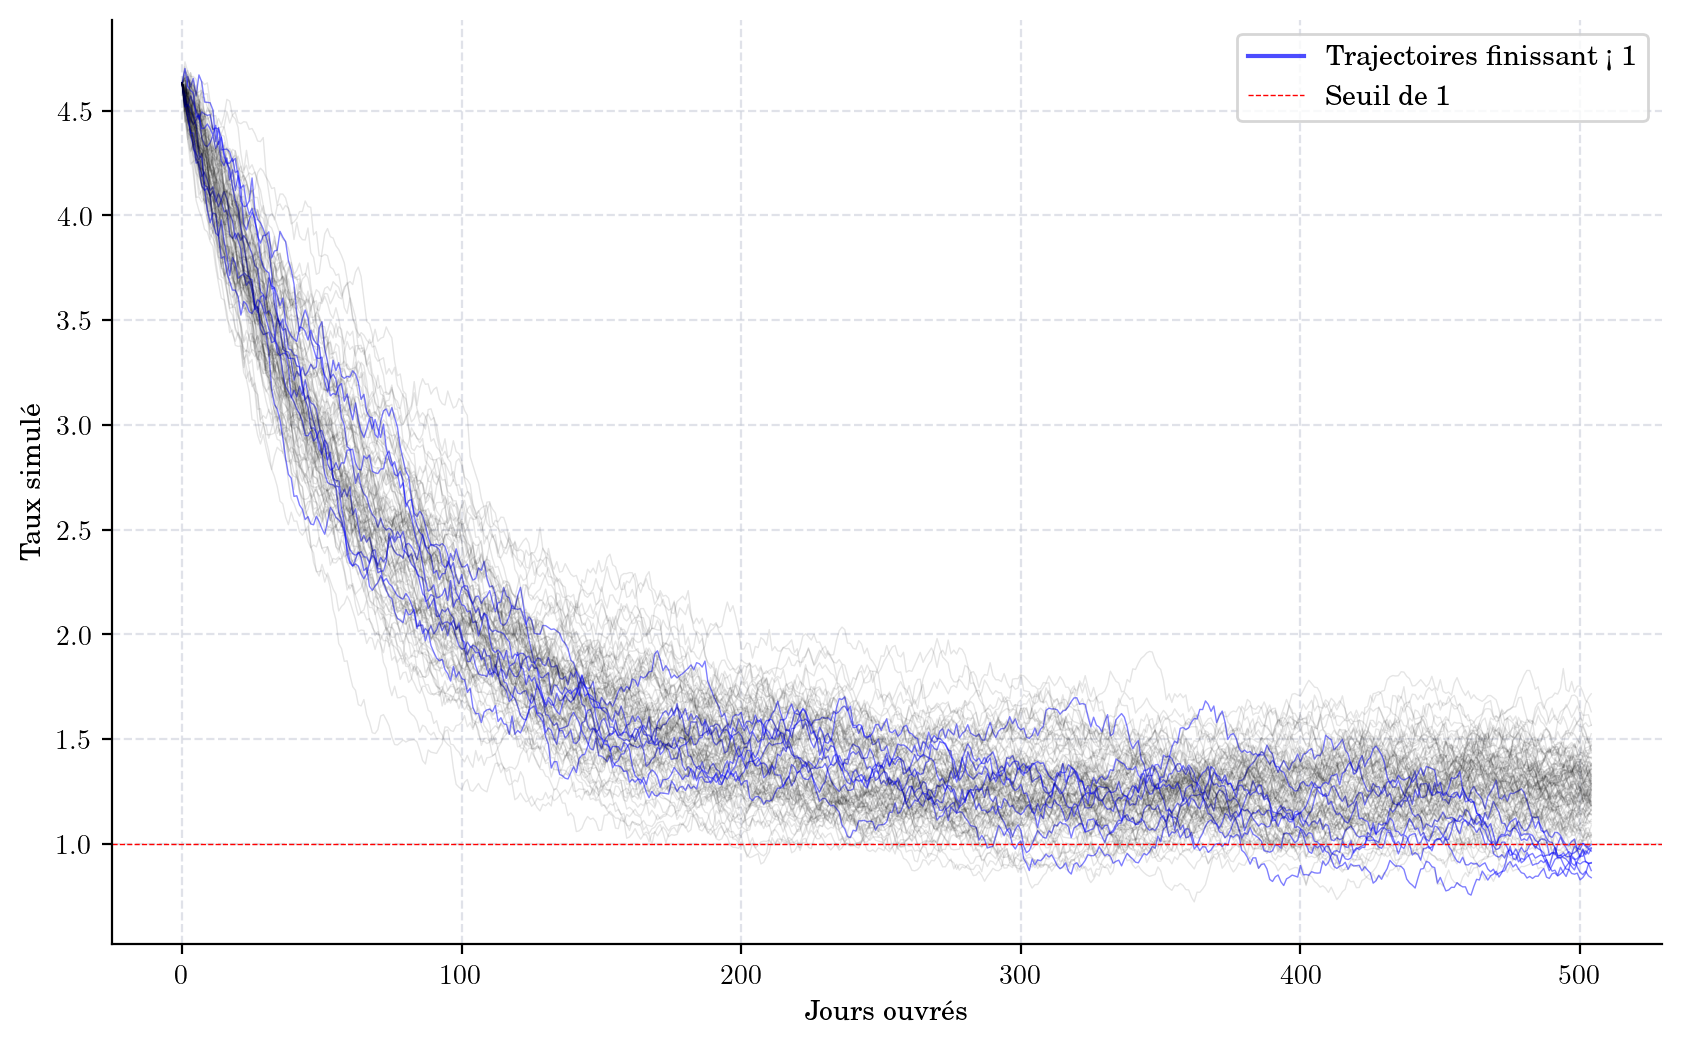

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# `df_initial` est le DataFrame d'origine avec les colonnes 'date' et 'value'
dates = pd.to_datetime(df_initial['date'])  # Conversion de la colonne 'date' en format datetime
historical_values = df_initial['value'].values  # Extraction des valeurs historiques en tableau numpy

# Convertir la date choisie
date_choisie = pd.to_datetime("2022-04-01")

# Filtrer les données à partir de la date choisie jusqu'à la fin du DataFrame
mask = dates >= date_choisie
dates = dates[mask]
historical_values = historical_values[mask]  # Application du masque de même longueur sur les deux tableaux

# Calcul des paramètres du modèle CIR (estimés précédemment)
alpha = -beta_2
beta = beta_1 / alpha
sigma = np.std(residuals) / np.sqrt(dt)
b = -13
T = 2

# Dernière valeur historique comme point de départ pour la simulation
r_0 = historical_values[-1]

# Paramètres de simulation
n_scenarios = 1000000   # Nombre de scénarios
n_steps = 252 * 2      # Nombre de pas pour 2 ans de simulation (252 jours ouvrés par an)
dt = 1 / 252           # Taille de chaque pas (un jour ouvré)

# Fonction de simulation Monte Carlo pour le modèle CIR avec échantillonnage préférentiel
def simulate_cir_échantillon(alpha, beta, sigma, r0, n_steps, n_scenarios):
    paths = np.zeros((n_steps + 1, n_scenarios))
    paths[0] = r0
    for i in range(1, n_steps + 1):
        drift = alpha * (beta - paths[i - 1]) + sigma * np.sqrt(np.maximum(paths[i - 1], 0)) * b
        diffusion = sigma * np.sqrt(np.maximum(paths[i - 1], 0)) * np.random.normal(size=n_scenarios)
        paths[i] = paths[i - 1] + drift * dt + diffusion * np.sqrt(dt)
    
    # Calcul de Z pour les scénarios
    mu = -0.5 * b**2 * T
    sigma_norm = -b * np.sqrt(T)
    normal_samples = np.random.normal(mu, sigma_norm, size=n_scenarios)
    Z = np.exp(normal_samples)

    return paths, Z

# Simuler les trajectoires et calculer le vecteur de correction Z
scenarios, Z = simulate_cir_échantillon(alpha, beta, sigma, r_0, n_steps, n_scenarios)

# Valeurs finales des trajectoires
final_values = scenarios[-1]

# Identifier les scénarios où la valeur finale est en dessous de 1%
below_threshold = final_values < 1

# Calculer la probabilité en appliquant l'échantillonnage pour les cas sous 1%
probability_below_1_percent = np.sum(Z[below_threshold])/n_scenarios

# Résultat formaté en notation scientifique
probability_formatted = f"{probability_below_1_percent:.6e}"
print(f"Probabilité ajustée que le taux simulé soit en dessous de 1% à 2 ans : {probability_formatted}")

# Tracer les trajectoires simulées
plt.figure(figsize=(10, 6))

# Tracer les trajectoires : bleu si elles terminent sous 1%, sinon noir
for i in range(min(100, n_scenarios)):
    if final_values[i] < 1:  # Vérifie si la trajectoire termine sous 1%
        plt.plot(scenarios[:, i], color='blue', alpha=0.5, linewidth=0.5)  # Bleu pour celles qui finissent sous 1%
    else:
        plt.plot(scenarios[:, i], color='black', alpha=0.1, linewidth=0.5)  # Noir pour les autres

# Ajouter une ligne de référence en bleu pour la légende des trajectoires sous 1 %
plt.plot([], [], color='blue', alpha=0.7, linewidth=1.5, label="Trajectoires finissant < 1%")

# Ajouter la ligne de la barrière à 1%
plt.axhline(1, color='red', linestyle="--", linewidth=0.5, label="Seuil de 1%")

# Paramètres du graphique
plt.xlabel("Jours ouvrés")
plt.ylabel("Taux simulé")
plt.legend()

# Sauvegarde en haute résolution
plt.savefig("importance_sampling_cir.png", dpi=300, bbox_inches='tight')
plt.show()

# Rajout de sauts
**Variable aléatoire exponential mixture :**

$$
f_X(x) = p \eta_1 e^{-x \eta_1} \mathbf{1}_{\{x > 0\}} + (1 - p) \eta_2 e^{\eta_2 x} \mathbf{1}_{\{x < 0\}}.
$$

In [53]:
def simulate_mixture_exponential(sample_size, p, eta1, eta2):
    """
    Simule un échantillon de variables aléatoires suivant la densité mixte donnée.
    
    Arguments :
    - sample_size : taille de l'échantillon
    - p : probabilité d'avoir une exponentielle positive (x > 0)
    - eta1 : paramètre de l'exponentielle pour x > 0
    - eta2 : paramètre de l'exponentielle pour x < 0
    
    Retourne :
    - np.array contenant les valeurs simulées
    """
    # Étape 1 : Tirage des composantes (Bernoulli)
    bernoulli_trials = np.random.binomial(1, p, sample_size)
    
    # Étape 2 : Tirage des valeurs selon la composante choisie
    positive_exponentials = np.random.exponential(1 / eta1, sample_size)
    negative_exponentials = -np.random.exponential(1 / eta2, sample_size)
    
    # Étape 3 : Combinaison des résultats
    samples = np.where(bernoulli_trials == 1, positive_exponentials, negative_exponentials)
    
    return samples

**Processus de comptage déterministe:**

$$ N_t = \sup \{ k \in \mathbb{N} : t \geq k \times 0.25 \} =  \lfloor 4t \rfloor $$


**Schéma d'Euler :**

$$R_{t + h} = R_t + \alpha (\beta - R_t) h + \sigma \sqrt{\max(0, R_t)} \sqrt{h} \, Z_t + (J_{t + h} - J_t)$$


**Remaque :** On remarque pas vraiment les sauts. 

Sous forme de fonction pour calculer les var...

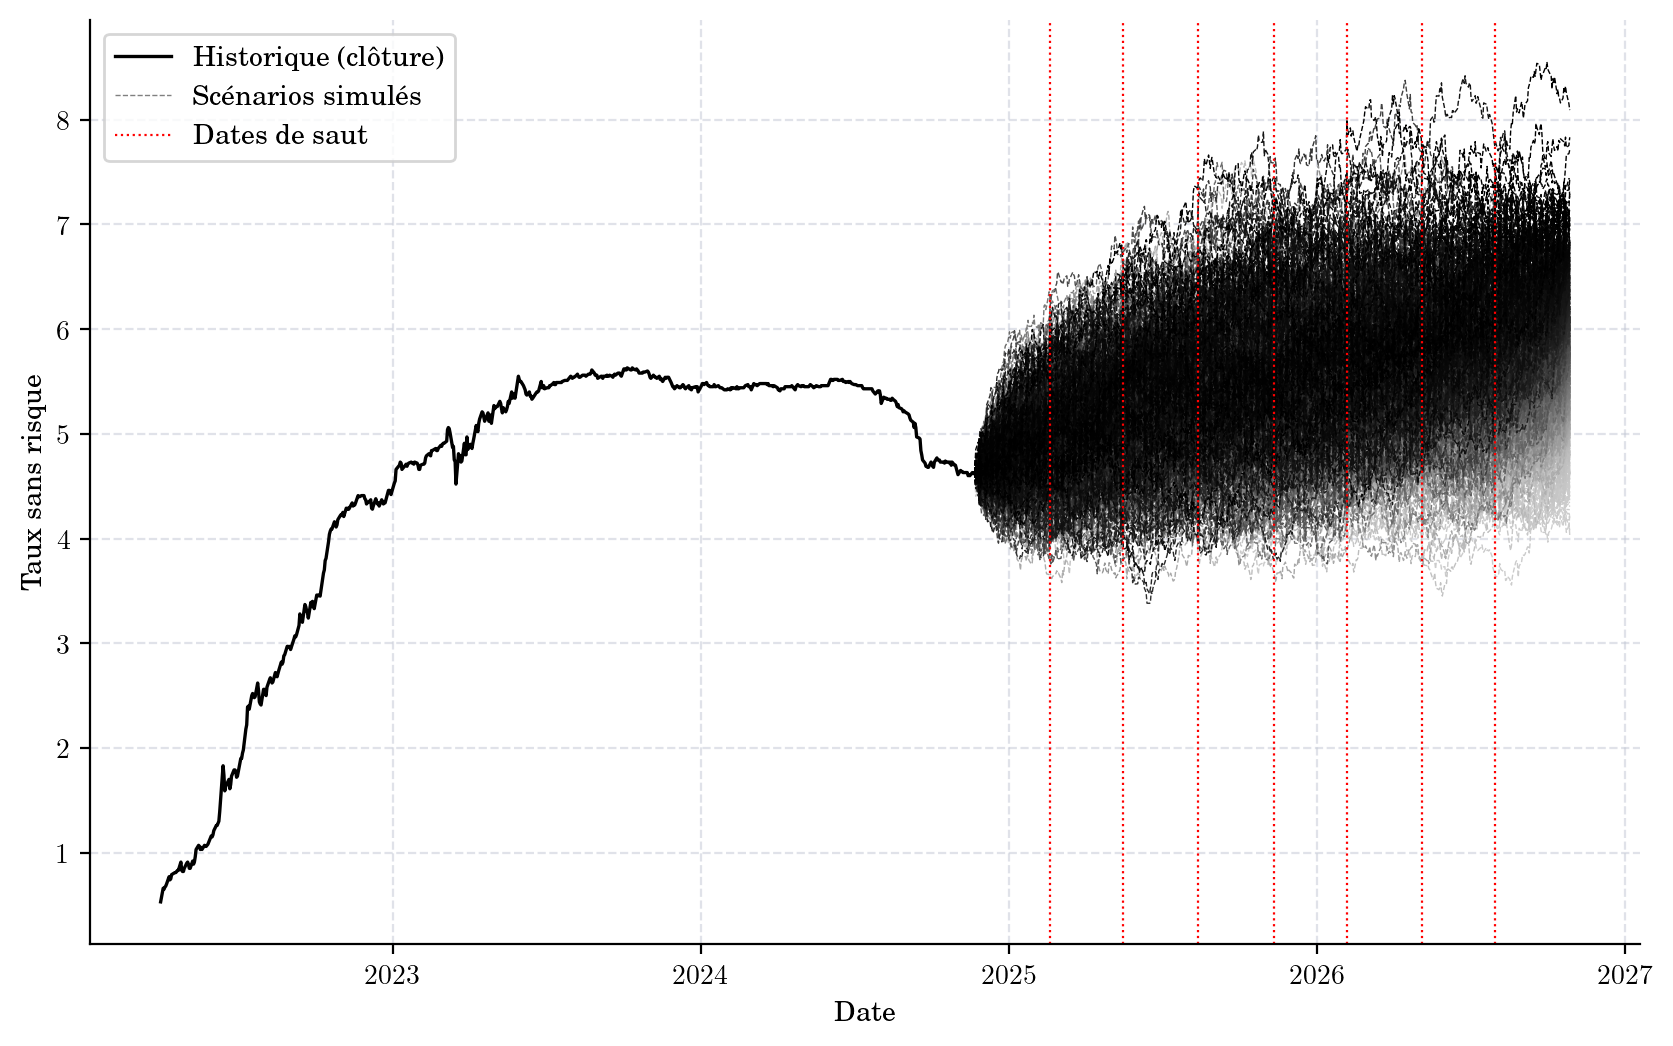

In [58]:
# Paramètres estimés
alpha = alpha_hat  # Estimation de alpha
beta = beta_hat    # Estimation de beta
sigma = np.sqrt(sigma2_hat)  # Écart-type estimé

# Paramètres pour le processus de saut
p = 0.5
eta1 = 1 / 0.1
eta2 = 1 / 0.05
jump_interval = 63  # Environ un trimestre (63 jours ouvrés)

# Extraire les données historiques
dates = df['date']
historical_values = df['value'].values
r_0 = historical_values[-1]

# Paramètres de simulation
n_scenarios = 1000
n_steps = 504
dt = 1 / 252

# Initialisation des trajectoires
scenarios = np.zeros((n_steps, n_scenarios))
scenarios[0] = r_0

# Générer des scénarios
jump_indices = []  # Liste pour stocker les indices de saut
for i in range(1, n_steps):
    drift = alpha * (beta - scenarios[i-1])
    diffusion = sigma * np.sqrt(np.maximum(scenarios[i-1], 0)) * np.random.normal(size=n_scenarios)
    scenarios[i] = scenarios[i-1] + drift * dt + diffusion * np.sqrt(dt)
    
    # Ajouter un saut tous les trimestres
    if i % jump_interval == 0:
        jumps = simulate_mixture_exponential(n_scenarios, p, eta1, eta2)
        scenarios[i] += jumps
        jump_indices.append(i)  # Enregistrer l'index où le saut se produit

# Calcul des valeurs finales de chaque trajectoire
final_values = scenarios[-1]

# Obtenir une palette de gris, du plus clair (faible) au plus foncé (élevé)
colors = cm.Greys(np.linspace(0.3, 1, n_scenarios))

# Triez les indices des scénarios en fonction de leurs valeurs finales pour assigner les couleurs
sorted_indices = np.argsort(final_values)

# Tracé des données historiques en noir
plt.figure(figsize=(10, 6))
plt.plot(dates, historical_values, lw=1.2, label="Historique (clôture)", color='black')

# Étendre les dates pour les scénarios simulés
last_date = dates.iloc[-1]
future_dates = pd.date_range(last_date, periods=n_steps, freq='B')

# Tracé des scénarios simulés avec la palette de gris ordonnée par valeur finale
for rank, j in enumerate(sorted_indices):  # `rank` est l'ordre des couleurs, `j` l'index du scénario
    plt.plot(future_dates, scenarios[:, j], lw=0.5, linestyle='--', color=colors[rank],
             label='Scénarios simulés' if rank == 0 else "")

# Ajouter des traits rouges aux dates de saut
for idx in jump_indices:
    plt.axvline(future_dates[idx], color='red', linestyle=':', lw=0.8)

# Créer un élément de légende personnalisé pour les sauts
jump_legend = Line2D([0], [0], color='red', linestyle=':', lw=0.8, label="Dates de saut")

# Légende finale
plt.xlabel("Date")
plt.ylabel("Taux sans risque")

# Ajouter tous les éléments de légende
plt.legend(handles=[Line2D([0], [0], color='black', lw=1.2, label="Historique (clôture)"),
                    Line2D([0], [0], color='gray', linestyle='--', lw=0.5, label="Scénarios simulés"),
                    jump_legend],
           loc="upper left", fontsize=10)


plt.savefig("scenarios_sauts.png", dpi=300, bbox_inches='tight')
# Affichage
plt.show()

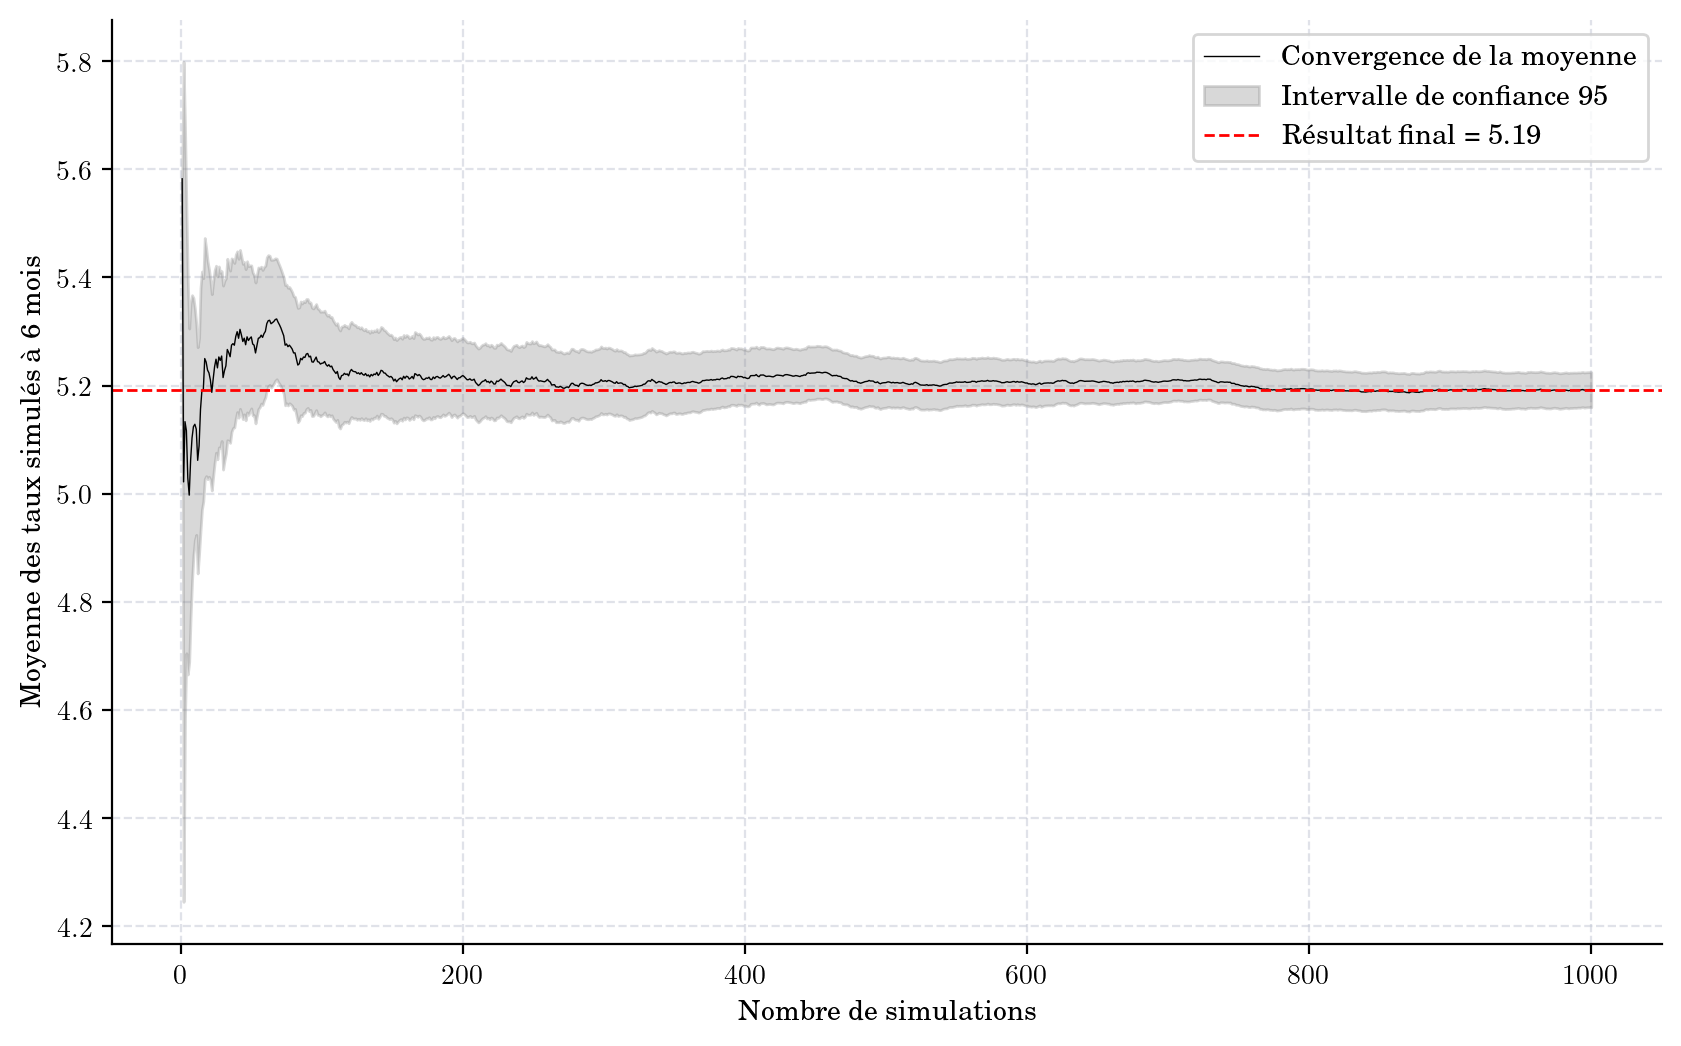

In [59]:
# Paramètres estimés
alpha = alpha_hat  # Estimation de alpha
beta = beta_hat    # Estimation de beta
sigma = np.sqrt(sigma2_hat)  # Écart-type estimé

# Paramètres pour le processus de saut
p = 0.5
eta1 = 1 / 0.1
eta2 = 1 / 0.05
jump_interval = 63  # Environ un trimestre (63 jours ouvrés)

# Extraire les données historiques
dates = df['date']
historical_values = df['value'].values
r_0 = historical_values[-1]

# Paramètres de simulation
n_scenarios = 1000
n_steps = 252
dt = 1 / 252
target_horizon = int(252 / 2)  # Correspond à environ 6 mois (126 jours ouvrés)

# Initialisation des trajectoires et de la liste pour stocker les valeurs à 6 mois
scenarios = np.zeros((n_steps, n_scenarios))
scenarios[0] = r_0
six_month_values = np.zeros(n_scenarios)

# Générer les scénarios
for i in range(1, n_steps):
    drift = alpha * (beta - scenarios[i - 1])
    diffusion = sigma * np.sqrt(np.maximum(scenarios[i - 1], 0)) * np.random.normal(size=n_scenarios)
    scenarios[i] = scenarios[i - 1] + drift * dt + diffusion * np.sqrt(dt)
    
    # Ajouter un saut tous les trimestres
    if i % jump_interval == 0:
        jumps = simulate_mixture_exponential(n_scenarios, p, eta1, eta2)
        scenarios[i] += jumps

# Enregistrer les valeurs de chaque trajectoire à 6 mois (126 jours)
six_month_values = scenarios[target_horizon]

# Monte Carlo : calcul de la moyenne et de l'intervalle de confiance
convergence_means = []
confidence_intervals = []

for i in range(1, n_scenarios + 1):
    mean_6_months = np.mean(six_month_values[:i])
    convergence_means.append(mean_6_months)
    
    # Calcul de l'intervalle de confiance (écart-type de l'estimation / racine carrée du nombre de simulations)
    std_error = np.std(six_month_values[:i]) / np.sqrt(i)
    confidence_intervals.append(1.96 * std_error)  # Intervalle de confiance à 95%

# Obtenir la moyenne finale avec 3 chiffres significatifs
final_mean = convergence_means[-1]
final_mean_formatted = f"{final_mean:.3g}"

# Tracer le graphe de convergence avec intervalle de confiance
plt.figure(figsize=(10, 6))

# Courbe de convergence de la moyenne
plt.plot(range(1, n_scenarios + 1), convergence_means, label="Convergence de la moyenne", color="black", linewidth=0.5)

# Intervalle de confiance autour de la moyenne
upper_bound = [m + ci for m, ci in zip(convergence_means, confidence_intervals)]
lower_bound = [m - ci for m, ci in zip(convergence_means, confidence_intervals)]
plt.fill_between(range(1, n_scenarios + 1), lower_bound, upper_bound, color='gray', alpha=0.3, label="Intervalle de confiance 95%")

# Ligne de la moyenne finale avec la valeur formatée dans la légende
plt.axhline(final_mean, color='red', linestyle="--", linewidth=1, label=f"Résultat final = {final_mean_formatted}")

# Paramètres du graphique
plt.xlabel("Nombre de simulations")
plt.ylabel("Moyenne des taux simulés à 6 mois")
plt.legend()

plt.savefig("sauts_6mois.png", dpi=300, bbox_inches='tight')
# Afficher le graphique
plt.show()


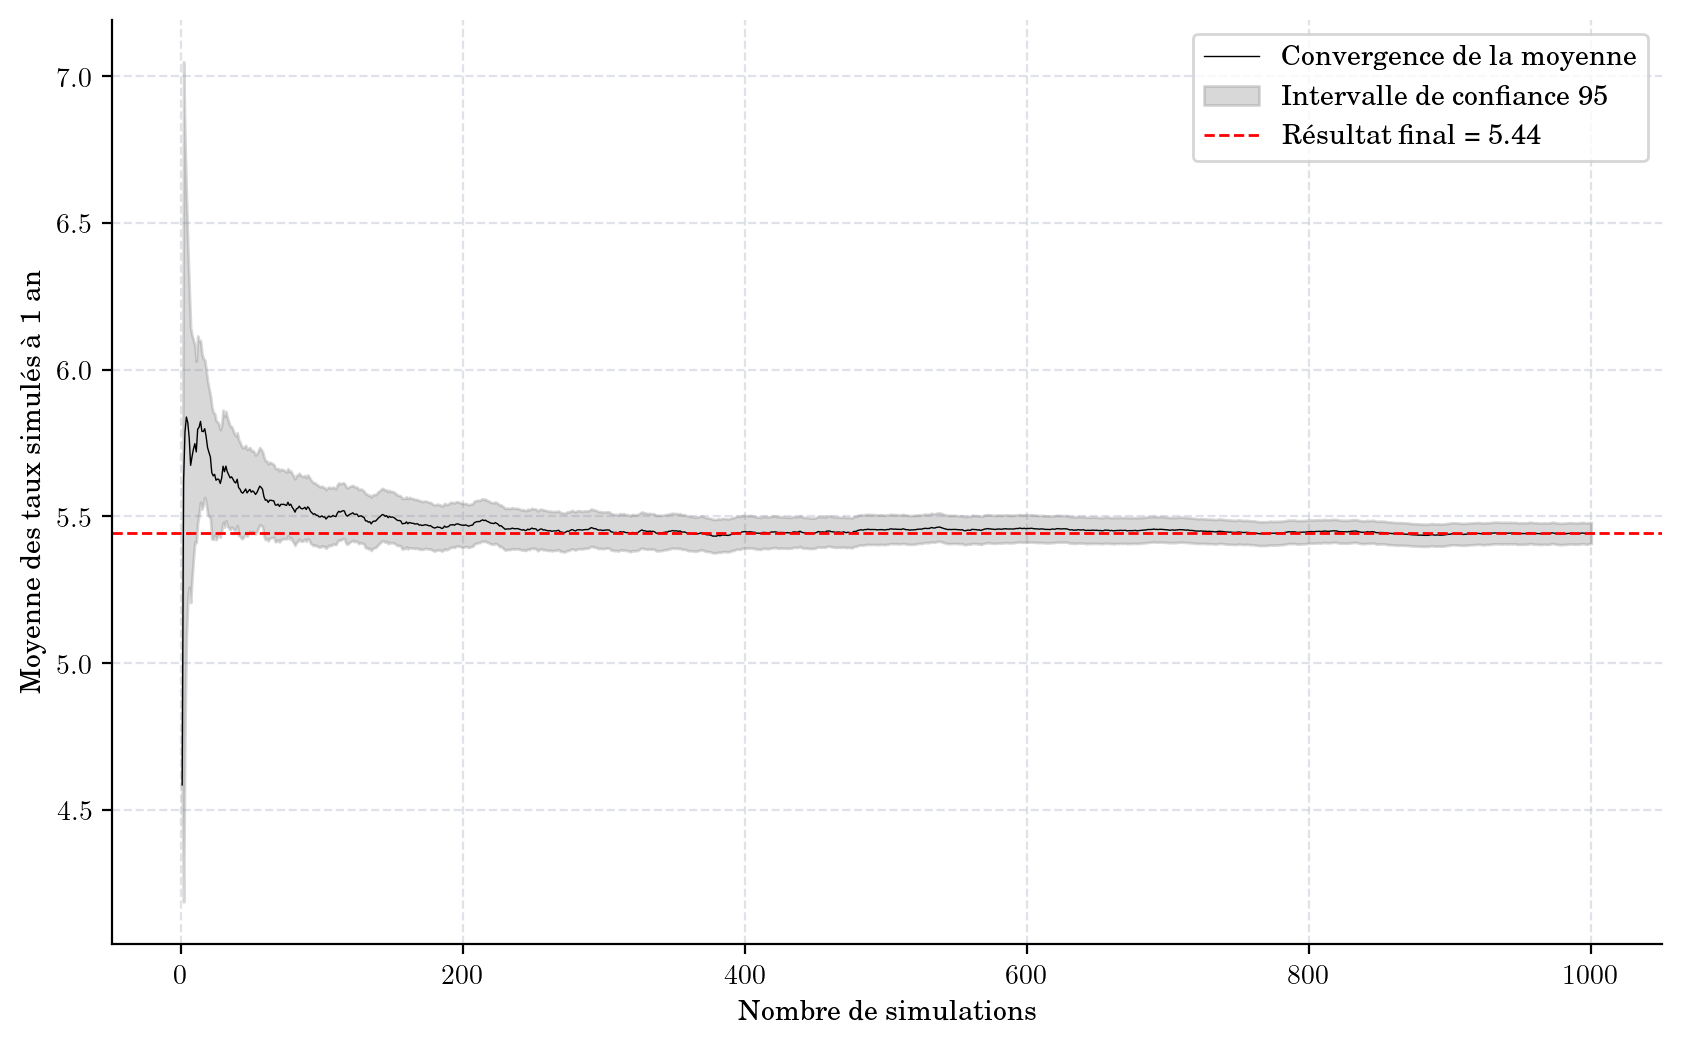

In [60]:
# Paramètres estimés
alpha = alpha_hat  # Estimation de alpha
beta = beta_hat    # Estimation de beta
sigma = np.sqrt(sigma2_hat)  # Écart-type estimé

# Paramètres pour le processus de saut
p = 0.5
eta1 = 1 / 0.1
eta2 = 1 / 0.05
jump_interval = 63  # Environ un trimestre (63 jours ouvrés)

# Extraire les données historiques
dates = df['date']
historical_values = df['value'].values
r_0 = historical_values[-1]

# Paramètres de simulation
n_scenarios = 1000
n_steps = 252  # Correspond à 1 an pour l'estimation du taux à 1 an
dt = 1 / 252

# Initialisation des trajectoires et de la liste pour stocker les valeurs à 1 an
scenarios = np.zeros((n_steps, n_scenarios))
scenarios[0] = r_0
one_year_values = np.zeros(n_scenarios)

# Générer les scénarios
for i in range(1, n_steps):
    drift = alpha * (beta - scenarios[i - 1])
    diffusion = sigma * np.sqrt(np.maximum(scenarios[i - 1], 0)) * np.random.normal(size=n_scenarios)
    scenarios[i] = scenarios[i - 1] + drift * dt + diffusion * np.sqrt(dt)
    
    # Ajouter un saut tous les trimestres
    if i % jump_interval == 0:
        jumps = simulate_mixture_exponential(n_scenarios, p, eta1, eta2)
        scenarios[i] += jumps

# Enregistrer les valeurs de chaque trajectoire à 1 an (252 jours)
one_year_values = scenarios[-1]

# Monte Carlo : calcul de la moyenne et de l'intervalle de confiance
convergence_means = []
confidence_intervals = []

for i in range(1, n_scenarios + 1):
    mean_1_year = np.mean(one_year_values[:i])
    convergence_means.append(mean_1_year)
    
    # Calcul de l'intervalle de confiance (écart-type de l'estimation / racine carrée du nombre de simulations)
    std_error = np.std(one_year_values[:i]) / np.sqrt(i)
    confidence_intervals.append(1.96 * std_error)  # Intervalle de confiance à 95%

# Obtenir la moyenne finale avec 3 chiffres significatifs
final_mean = convergence_means[-1]
final_mean_formatted = f"{final_mean:.3g}"

# Tracer le graphe de convergence avec intervalle de confiance
plt.figure(figsize=(10, 6))

# Courbe de convergence de la moyenne
plt.plot(range(1, n_scenarios + 1), convergence_means, label="Convergence de la moyenne", color="black", linewidth=0.5)

# Intervalle de confiance autour de la moyenne
upper_bound = [m + ci for m, ci in zip(convergence_means, confidence_intervals)]
lower_bound = [m - ci for m, ci in zip(convergence_means, confidence_intervals)]
plt.fill_between(range(1, n_scenarios + 1), lower_bound, upper_bound, color='gray', alpha=0.3, label="Intervalle de confiance 95%")

# Ligne de la moyenne finale avec la valeur formatée dans la légende
plt.axhline(final_mean, color='red', linestyle="--", linewidth=1, label=f"Résultat final = {final_mean_formatted}")

# Paramètres du graphique
plt.xlabel("Nombre de simulations")
plt.ylabel("Moyenne des taux simulés à 1 an")
plt.legend()

plt.savefig("sauts_1A.png", dpi=300, bbox_inches='tight')
# Afficher le graphique
plt.show()